### Dice Coefficient 
##### This script is designed to quantify similarities and differences between two aspects of the visual pathway in object recognition.

In [ ]:
# FC and PPI dice coefficient
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy import stats

# Define study directories
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'
output_dir = f'{results_dir}/dice_comparison'
os.makedirs(output_dir, exist_ok=True)

def dice_coefficient(img1_data, img2_data):
    """Calculate Dice coefficient between two binary arrays."""
    # Ensure binary
    img1_bin = (img1_data > 0).astype(int)
    img2_bin = (img2_data > 0).astype(int)
    
    # Calculate intersection
    intersection = np.sum(img1_bin * img2_bin)
    
    # Calculate Dice using formula: 2*intersection/(sum of elements)
    dice = 2.0 * intersection / (np.sum(img1_bin) + np.sum(img2_bin))
    
    return dice

def analyze_data_type(analysis_type):
    """Analyze dice coefficients for a specific data type (fc or ppi)"""
    print(f"\n{'='*80}")
    print(f"ANALYZING {analysis_type.upper()} MAPS")
    print(f"{'='*80}")
    
    # Load subject info
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    
    # Exclude sub-084 as specified
    if 'sub-084' in subjects:
        subjects.remove('sub-084')
        print("Excluded sub-084 from analysis")
    
    print(f"Found {len(subjects)} control subjects")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    
    # Load and preprocess subject data
    subject_data = {}
    valid_subjects = []
    
    for sub in subjects:
        has_all_data = True
        subject_data[sub] = {}
        
        for roi in rois:
            # Initialize lists to store hemisphere data
            roi_data_arrays = []
            
            for hemi in hemispheres:
                # Both FC and PPI files are in the same directory but with different analysis_type in the filename
                roi_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemi}_loc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(roi_file):
                    try:
                        img = nib.load(roi_file)
                        roi_data_arrays.append(img.get_fdata())
                    except Exception as e:
                        print(f"Error loading {roi_file}: {e}")
                        has_all_data = False
                else:
                    print(f"File not found: {roi_file}")
                    has_all_data = False
            
            # Average the hemispheres if we have data for both
            if len(roi_data_arrays) == 2:
                # Create averaged map
                avg_data = (roi_data_arrays[0] + roi_data_arrays[1]) / 2
                subject_data[sub][roi] = avg_data
            else:
                has_all_data = False
        
        if has_all_data:
            valid_subjects.append(sub)
    
    print(f"Found {len(valid_subjects)} subjects with complete {analysis_type} data")
    
    if len(valid_subjects) == 0:
        print(f"No valid subjects found for {analysis_type} analysis. Skipping.")
        return None
    
    # 1. Within-subject, between-ROI analysis (pIPS vs LO)
    print(f"\nCalculating within-subject, between-ROI dice coefficients for {analysis_type}...")
    between_roi_results = []
    
    for sub in valid_subjects:
        try:
            # Calculate Dice coefficient
            dice_score = dice_coefficient(subject_data[sub]['pIPS'], subject_data[sub]['LO'])
            
            between_roi_results.append({
                'Subject': sub,
                'Analysis': analysis_type,
                'Dice': dice_score
            })
            
            print(f"Subject {sub}, {analysis_type}, pIPS vs LO: {dice_score:.4f}")
        except Exception as e:
            print(f"Error processing subject {sub}: {e}")
    
    # Convert to DataFrame
    between_roi_df = pd.DataFrame(between_roi_results)
    
    # Calculate statistics
    mean = between_roi_df['Dice'].mean()
    std = between_roi_df['Dice'].std()
    # 95% confidence interval
    ci = stats.t.interval(0.95, len(between_roi_df)-1, loc=mean, scale=std/np.sqrt(len(between_roi_df)))
    
    print(f"\n{analysis_type.upper()}: pIPS vs LO within-subject similarity:")
    print(f"Mean Dice: {mean:.4f} ± {std:.4f}")
    print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")
    print(f"N = {len(between_roi_df)} subjects")
    
    # 2. Between-subject, within-ROI analysis
    print(f"\nCalculating between-subject, within-ROI dice coefficients for {analysis_type}...")
    within_roi_results = []
    
    for roi in rois:
        # Compare each subject to all others
        for i, sub1 in enumerate(valid_subjects):
            for j, sub2 in enumerate(valid_subjects):
                if i < j:  # Only compare each pair once
                    try:
                        # Calculate Dice coefficient
                        dice_score = dice_coefficient(subject_data[sub1][roi], subject_data[sub2][roi])
                        
                        within_roi_results.append({
                            'ROI': roi,
                            'Analysis': analysis_type,
                            'Subject1': sub1,
                            'Subject2': sub2,
                            'Dice': dice_score
                        })
                    except Exception as e:
                        print(f"Error comparing {sub1} and {sub2} for {roi}: {e}")
    
    # Convert to DataFrame
    within_roi_df = pd.DataFrame(within_roi_results)
    
    # Calculate statistics for each ROI
    within_roi_stats = []
    
    for roi in rois:
        roi_data = within_roi_df[within_roi_df['ROI'] == roi]
        
        if len(roi_data) > 0:
            mean = roi_data['Dice'].mean()
            std = roi_data['Dice'].std()
            # 95% confidence interval
            ci = stats.t.interval(0.95, len(roi_data)-1, loc=mean, scale=std/np.sqrt(len(roi_data)))
            
            within_roi_stats.append({
                'ROI': roi,
                'Analysis': analysis_type,
                'Mean Dice': mean,
                'Std Dev': std,
                '95% CI Lower': ci[0],
                '95% CI Upper': ci[1],
                'N': len(roi_data)
            })
            
            print(f"\n{analysis_type.upper()}: {roi} between-subject similarity:")
            print(f"Mean Dice: {mean:.4f} ± {std:.4f}")
            print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")
            print(f"Based on {len(roi_data)} comparisons among {len(valid_subjects)} subjects")
    
    # Save results to CSV files
    between_roi_df.to_csv(f'{output_dir}/{analysis_type}_between_roi_dice_by_subject.csv', index=False)
    within_roi_df.to_csv(f'{output_dir}/{analysis_type}_within_roi_dice_by_pair.csv', index=False)
    
    within_roi_stats_df = pd.DataFrame(within_roi_stats)
    within_roi_stats_df.to_csv(f'{output_dir}/{analysis_type}_within_roi_stats.csv', index=False)
    
    # Prepare summary data
    between_roi_stats = {
        'ROI': 'pIPS vs LO',
        'Analysis': analysis_type,
        'Mean Dice': between_roi_df['Dice'].mean(),
        'Std Dev': between_roi_df['Dice'].std(),
        '95% CI Lower': ci[0],
        '95% CI Upper': ci[1],
        'N': len(between_roi_df)
    }
    
    # Combine all stats into one DataFrame
    all_stats = pd.DataFrame([between_roi_stats] + within_roi_stats)
    
    return {
        'between_roi': between_roi_df,
        'within_roi': within_roi_df,
        'stats': all_stats
    }

def main():
    """Analyze both FC and PPI data"""
    results = {}
    all_stats = []
    
    # Analyze FC data
    print("\nAnalyzing FC data...")
    fc_results = analyze_data_type('fc')
    if fc_results:
        results['fc'] = fc_results
        all_stats.append(fc_results['stats'])
    
    # Analyze PPI data
    print("\nAnalyzing PPI data...")
    ppi_results = analyze_data_type('ppi')
    if ppi_results:
        results['ppi'] = ppi_results
        all_stats.append(ppi_results['stats'])
    
    # Combine stats from both analyses
    if all_stats:
        combined_stats = pd.concat(all_stats)
        combined_stats.to_csv(f'{output_dir}/combined_dice_stats.csv', index=False)
        
        # Print combined summary
        print("\n\nCOMBINED SUMMARY OF DICE COEFFICIENT ANALYSES")
        print("=" * 80)
        print(combined_stats.to_string(index=False))
        
        # Create comparison table for FC vs PPI
        if 'fc' in results and 'ppi' in results:
            comparison = combined_stats.pivot(index='ROI', columns='Analysis', values='Mean Dice')
            comparison['Difference'] = comparison['ppi'] - comparison['fc']
            
            print("\n\nFC vs PPI COMPARISON")
            print("=" * 80)
            print(comparison.to_string())
            
            comparison.to_csv(f'{output_dir}/fc_vs_ppi_comparison.csv')
    
    return results

if __name__ == "__main__":
    results = main()

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



Analyzing FC data...

ANALYZING FC MAPS
Excluded sub-084 from analysis
Found 18 control subjects
Found 18 subjects with complete fc data

Calculating within-subject, between-ROI dice coefficients for fc...
Subject sub-025, fc, pIPS vs LO: 0.7674
Subject sub-038, fc, pIPS vs LO: 0.8994
Subject sub-057, fc, pIPS vs LO: 0.9702
Subject sub-059, fc, pIPS vs LO: 0.9561
Subject sub-064, fc, pIPS vs LO: 0.8788
Subject sub-067, fc, pIPS vs LO: 0.9832
Subject sub-068, fc, pIPS vs LO: 0.9224
Subject sub-071, fc, pIPS vs LO: 0.9688
Subject sub-083, fc, pIPS vs LO: 0.9507
Subject sub-085, fc, pIPS vs LO: 0.8597
Subject sub-087, fc, pIPS vs LO: 0.9086
Subject sub-088, fc, pIPS vs LO: 0.9605
Subject sub-093, fc, pIPS vs LO: 0.9523
Subject sub-094, fc, pIPS vs LO: 0.8894
Subject sub-095, fc, pIPS vs LO: 0.9449
Subject sub-096, fc, pIPS vs LO: 0.9090
Subject sub-097, fc, pIPS vs LO: 0.8686
Subject sub-107, fc, pIPS vs LO: 0.8695

FC: pIPS vs LO within-subject similarity:
Mean Dice: 0.9144 ± 0.0539
95%

In [ ]:
# FC and PPI ANOVA dice coefficient
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.multitest import multipletests

def compare_within_vs_between_dice_anova_averaged(analysis_type='fc'):
    """
    Independent function to compare within-ROI vs between-ROI dice coefficients 
    using ANOVA with subject-level averages for better statistical properties.
    Now supports both FC and PPI analysis types.
    
    Parameters:
    -----------
    analysis_type : str
        Type of analysis to perform, either 'fc' or 'ppi'
    """
    # Define study directories
    study_dir = "/lab_data/behrmannlab/vlad/ptoc"
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
    sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'
    output_dir = f'{results_dir}/dice_comparison'
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Comparing within-ROI vs between-ROI dice coefficients using ANOVA with subject averages for {analysis_type.upper()}...")
    
    # Load subject info
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    
    # Exclude sub-084 as specified
    if 'sub-084' in subjects:
        subjects.remove('sub-084')
        print("Excluded sub-084 from analysis")
    
    print(f"Found {len(subjects)} control subjects")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    
    # Load and preprocess subject data
    subject_data = {}
    valid_subjects = []
    
    for sub in subjects:
        has_all_data = True
        subject_data[sub] = {}
        
        for roi in rois:
            # Initialize lists to store hemisphere data
            roi_data_arrays = []
            
            for hemi in hemispheres:
                roi_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemi}_loc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(roi_file):
                    try:
                        img = nib.load(roi_file)
                        roi_data_arrays.append(img.get_fdata())
                    except Exception as e:
                        print(f"Error loading {roi_file}: {e}")
                        has_all_data = False
                else:
                    print(f"File not found: {roi_file}")
                    has_all_data = False
            
            # Average the hemispheres if we have data for both
            if len(roi_data_arrays) == 2:
                # Create averaged map
                avg_data = (roi_data_arrays[0] + roi_data_arrays[1]) / 2
                subject_data[sub][roi] = (avg_data > 0).astype(int)  # Binarize
            else:
                has_all_data = False
        
        if has_all_data:
            valid_subjects.append(sub)
    
    print(f"Found {len(valid_subjects)} subjects with complete {analysis_type} data")
    
    if len(valid_subjects) == 0:
        print(f"No valid subjects found for {analysis_type} analysis. Skipping.")
        return None
    
    # 1. Within-subject, between-ROI analysis (pIPS vs LO)
    print(f"\nCalculating within-subject, between-ROI dice coefficients for {analysis_type}...")
    between_roi_results = []
    
    for sub in valid_subjects:
        try:
            # Get binary maps
            pips_bin = subject_data[sub]['pIPS']
            lo_bin = subject_data[sub]['LO']
            
            # Calculate intersection
            intersection = np.sum(pips_bin * lo_bin)
            
            # Calculate Dice
            dice_score = 2.0 * intersection / (np.sum(pips_bin) + np.sum(lo_bin))
            
            between_roi_results.append({
                'Subject': sub,
                'Dice': dice_score,
                'Comparison': 'Within-subject_between-ROI'
            })
            
            print(f"Subject {sub}, pIPS vs LO: {dice_score:.4f}")
        except Exception as e:
            print(f"Error processing subject {sub}: {e}")
    
    # 2. Calculate all pairwise between-subject dice coefficients
    print(f"\nCalculating pairwise between-subject, within-ROI dice coefficients for {analysis_type}...")
    pairwise_results = {}
    
    for roi in rois:
        pairwise_results[roi] = {}
        # Initialize the nested dictionary structure
        for sub in valid_subjects:
            pairwise_results[roi][sub] = {}
        
        # Compare each subject to all others
        for i, sub1 in enumerate(valid_subjects):
            for j, sub2 in enumerate(valid_subjects):
                if i < j:  # Only compare each pair once
                    try:
                        # Get binary maps
                        map1 = subject_data[sub1][roi]
                        map2 = subject_data[sub2][roi]
                        
                        # Calculate intersection
                        intersection = np.sum(map1 * map2)
                        
                        # Calculate Dice
                        dice_score = 2.0 * intersection / (np.sum(map1) + np.sum(map2))
                        
                        # Store the result for both subjects
                        pairwise_results[roi][sub1][sub2] = dice_score
                        pairwise_results[roi][sub2][sub1] = dice_score
                    except Exception as e:
                        print(f"Error comparing {sub1} and {sub2} for {roi}: {e}")
    
    # 3. Average the between-subject dice coefficients for each subject
    print(f"\nAveraging between-subject dice coefficients for each subject for {analysis_type}...")
    average_results = []
    
    for roi in rois:
        for sub in pairwise_results[roi]:
            # Calculate the average dice with all other subjects
            if len(pairwise_results[roi][sub]) > 0:  # Ensure there are values to average
                avg_dice = np.mean(list(pairwise_results[roi][sub].values()))
                
                average_results.append({
                    'Subject': sub,
                    'ROI': roi,
                    'Dice': avg_dice,
                    'Comparison': f'Between-subject_within-{roi}'
                })
                print(f"Subject {sub}, average {roi} similarity with other subjects: {avg_dice:.4f}")
    
    # Combine results for ANOVA
    all_results = pd.DataFrame(between_roi_results)
    average_df = pd.DataFrame(average_results)
    
    # Create separate DataFrames for pIPS and LO
    pips_df = average_df[average_df['ROI'] == 'pIPS'].copy()
    lo_df = average_df[average_df['ROI'] == 'LO'].copy()
    
    # Calculate summary statistics
    print(f"\nSummary Statistics for {analysis_type.upper()}:")
    
    groups = {
        'Within-subject, between-ROI': all_results['Dice'].values,
        'Between-subject, within-pIPS': pips_df['Dice'].values,
        'Between-subject, within-LO': lo_df['Dice'].values
    }
    
    for group_name, values in groups.items():
        if len(values) > 0:
            mean = np.mean(values)
            std = np.std(values)
            ci = stats.t.interval(0.95, len(values)-1, loc=mean, scale=std/np.sqrt(len(values)))
            print(f"{group_name}:")
            print(f"  N = {len(values)}")
            print(f"  Mean = {mean:.4f} ± {std:.4f}")
            print(f"  95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")
    
    # Save summary statistics to CSV
    summary_stats = []
    for group_name, values in groups.items():
        if len(values) > 0:
            mean = np.mean(values)
            std = np.std(values)
            ci = stats.t.interval(0.95, len(values)-1, loc=mean, scale=std/np.sqrt(len(values)))
            summary_stats.append({
                'Analysis': analysis_type,
                'Group': group_name,
                'N': len(values),
                'Mean': mean,
                'Std': std,
                'CI_Lower': ci[0],
                'CI_Upper': ci[1]
            })
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv(f'{output_dir}/{analysis_type}_anova_summary_stats.csv', index=False)
    
    # Prepare data for ANOVA - now all groups should have the same sample size based on valid subjects
    anova_data = pd.DataFrame({
        'Dice': np.concatenate([
            all_results['Dice'].values,
            pips_df['Dice'].values,
            lo_df['Dice'].values
        ]),
        'Group': np.concatenate([
            ['Within-subject_between-ROI'] * len(all_results),
            ['Between-subject_within-pIPS'] * len(pips_df),
            ['Between-subject_within-LO'] * len(lo_df)
        ])
    })
    
    # Run One-way ANOVA
    print(f"\nPerforming One-way ANOVA with subject averages for {analysis_type}...")
    model = ols('Dice ~ C(Group)', data=anova_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print("\nANOVA Results:")
    print(anova_table)
    
    # Save ANOVA results to CSV
    anova_df = pd.DataFrame(anova_table)
    anova_df.to_csv(f'{output_dir}/{analysis_type}_anova_results.csv')
    

    # Calculate pairwise t-tests and apply Holm-Bonferroni correction
    unique_groups = anova_data['Group'].unique()
    p_values = []
    pairs = []

    for i, group1 in enumerate(unique_groups):
        for j, group2 in enumerate(unique_groups):
            if i < j:  # Compare each pair only once
                data1 = anova_data[anova_data['Group'] == group1]['Dice']
                data2 = anova_data[anova_data['Group'] == group2]['Dice']
                _, p_val = stats.ttest_ind(data1, data2, equal_var=False)
                p_values.append(p_val)
                pairs.append((group1, group2))

    # Apply Holm-Bonferroni correction
    reject, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')

    # Print results
    print("\nHolm-Bonferroni Results:")
    for i, ((group1, group2), p_corr, rej) in enumerate(zip(pairs, p_corrected, reject)):
        print(f"{group1} vs {group2}: p-corrected = {p_corr:.4f}, significant: {rej}")

    # Save results to a text file
    with open(f'{output_dir}/{analysis_type}_holm_bonferroni_results.txt', 'w') as f:
        f.write("Holm-Bonferroni corrected pairwise comparisons:\n\n")
        for i, ((group1, group2), p_corr, rej) in enumerate(zip(pairs, p_corrected, reject)):
            f.write(f"{group1} vs {group2}: p-corrected = {p_corr:.4f}, significant: {rej}\n")
    
    # Print interpretation
    print(f"\nINTERPRETATION for {analysis_type.upper()}:")
    f_value = anova_table['F'][0]
    p_value = anova_table['PR(>F)'][0]
    
    if p_value < 0.05:
        print(f"The ANOVA shows significant differences in Dice coefficients among the three comparison types (F={f_value:.4f}, p={p_value:.4f}).")
        print("The Holm Bonferroni post-hoc test shows which specific groups differ from each other.")
        print("\nBased on the means:")
        
        means = {
            'Within-subject_between-ROI': np.mean(groups['Within-subject, between-ROI']),
            'Between-subject_within-pIPS': np.mean(groups['Between-subject, within-pIPS']),
            'Between-subject_within-LO': np.mean(groups['Between-subject, within-LO'])
        }
        
        ordered_groups = sorted(means.items(), key=lambda x: x[1], reverse=True)
        
        for i, (group, mean) in enumerate(ordered_groups):
            print(f"{i+1}. {group}: {mean:.4f}")
        
        if means['Within-subject_between-ROI'] > means['Between-subject_within-pIPS'] and means['Within-subject_between-ROI'] > means['Between-subject_within-LO']:
            print("\nThis suggests that different ROIs within the same subject share more similar connectivity patterns")
            print("than the same ROI across different subjects. This pattern holds for both pIPS and LO.")
        else:
            print("\nThe pattern suggests a more complex relationship. Please refer to the Holm-Bon results for specific group differences.")
    else:
        print(f"The ANOVA shows no significant differences in Dice coefficients among the three comparison types (F={f_value:.4f}, p={p_value:.4f}).")
        print("This suggests that the level of similarity does not significantly differ between:")
        print("- different ROIs within the same subject")
        print("- the same ROI across different subjects")
    
    return {
        'anova_table': anova_table,
        'holm_result': {
            'pairs': pairs,
            'p_corrected': p_corrected,
            'reject': reject
        },
        'group_means': {
            'Within-subject_between-ROI': np.mean(groups['Within-subject, between-ROI']),
            'Between-subject_within-pIPS': np.mean(groups['Between-subject, within-pIPS']),
            'Between-subject_within-LO': np.mean(groups['Between-subject, within-LO'])
        }
    }

def main():
    """Run ANOVA comparisons for both FC and PPI data"""
    results = {}
    
    # Analyze FC data
    print("\nAnalyzing FC data...")
    fc_results = compare_within_vs_between_dice_anova_averaged('fc')
    if fc_results:
        results['fc'] = fc_results
    
    # Analyze PPI data
    print("\nAnalyzing PPI data...")
    ppi_results = compare_within_vs_between_dice_anova_averaged('ppi')
    if ppi_results:
        results['ppi'] = ppi_results
    
    # Compare FC vs PPI results if both analyses completed successfully
    if 'fc' in results and 'ppi' in results:
        print("\n\nCOMPARING FC vs PPI RESULTS")
        print("=" * 80)
        
        # Create comparison table
        comparison = {
            'Group': list(results['fc']['group_means'].keys()),
            'FC_Mean': list(results['fc']['group_means'].values()),
            'PPI_Mean': list(results['ppi']['group_means'].values())
        }
        
        comparison_df = pd.DataFrame(comparison)
        comparison_df['Difference'] = comparison_df['PPI_Mean'] - comparison_df['FC_Mean']
        
        print(comparison_df.to_string(index=False))
        
        # Save comparison to CSV
        output_dir = f'/user_data/csimmon2/git_repos/ptoc/results/dice_comparison'
        comparison_df.to_csv(f'{output_dir}/fc_vs_ppi_anova_comparison.csv', index=False)
        
        # Provide interpretation of differences
        print("\nINTERPRETATION OF FC vs PPI COMPARISON:")
        for group in comparison_df['Group']:
            fc_mean = results['fc']['group_means'][group]
            ppi_mean = results['ppi']['group_means'][group]
            diff = ppi_mean - fc_mean
            
            if abs(diff) < 0.01:
                print(f"- {group}: Very similar Dice coefficients between FC and PPI (diff: {diff:.4f})")
            elif diff > 0:
                print(f"- {group}: PPI shows higher similarity than FC (diff: {diff:.4f})")
            else:
                print(f"- {group}: FC shows higher similarity than PPI (diff: {diff:.4f})")
    
    return results

if __name__ == "__main__":
    results = main()


Analyzing FC data...
Comparing within-ROI vs between-ROI dice coefficients using ANOVA with subject averages for FC...
Excluded sub-084 from analysis
Found 18 control subjects
Found 18 subjects with complete fc data

Calculating within-subject, between-ROI dice coefficients for fc...
Subject sub-025, pIPS vs LO: 0.7674
Subject sub-038, pIPS vs LO: 0.8994
Subject sub-057, pIPS vs LO: 0.9702
Subject sub-059, pIPS vs LO: 0.9561
Subject sub-064, pIPS vs LO: 0.8788
Subject sub-067, pIPS vs LO: 0.9832
Subject sub-068, pIPS vs LO: 0.9224
Subject sub-071, pIPS vs LO: 0.9688
Subject sub-083, pIPS vs LO: 0.9507
Subject sub-085, pIPS vs LO: 0.8597
Subject sub-087, pIPS vs LO: 0.9086
Subject sub-088, pIPS vs LO: 0.9605
Subject sub-093, pIPS vs LO: 0.9523
Subject sub-094, pIPS vs LO: 0.8894
Subject sub-095, pIPS vs LO: 0.9449
Subject sub-096, pIPS vs LO: 0.9090
Subject sub-097, pIPS vs LO: 0.8686
Subject sub-107, pIPS vs LO: 0.8695

Calculating pairwise between-subject, within-ROI dice coefficient

/tmp/ipykernel_22760/1006248671.py:269: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_22760/1006248671.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


Found 18 subjects with complete ppi data

Calculating within-subject, between-ROI dice coefficients for ppi...
Subject sub-025, pIPS vs LO: 0.7072
Subject sub-038, pIPS vs LO: 0.7988
Subject sub-057, pIPS vs LO: 0.9275
Subject sub-059, pIPS vs LO: 0.8801
Subject sub-064, pIPS vs LO: 0.6038
Subject sub-067, pIPS vs LO: 0.7652
Subject sub-068, pIPS vs LO: 0.8257
Subject sub-071, pIPS vs LO: 0.8305
Subject sub-083, pIPS vs LO: 0.7645
Subject sub-085, pIPS vs LO: 0.8298
Subject sub-087, pIPS vs LO: 0.8670
Subject sub-088, pIPS vs LO: 0.8273
Subject sub-093, pIPS vs LO: 0.9517
Subject sub-094, pIPS vs LO: 0.7325
Subject sub-095, pIPS vs LO: 0.8934
Subject sub-096, pIPS vs LO: 0.7577
Subject sub-097, pIPS vs LO: 0.8600
Subject sub-107, pIPS vs LO: 0.8003

Calculating pairwise between-subject, within-ROI dice coefficients for ppi...

Averaging between-subject dice coefficients for each subject for ppi...
Subject sub-025, average pIPS similarity with other subjects: 0.4946
Subject sub-038, ave

/tmp/ipykernel_22760/1006248671.py:269: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_22760/1006248671.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


Visualizing FC analysis...


/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int64 to float64
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int64 to float64
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:292: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  "Resampling binary images with continuous or "


Found optimal coordinates for fc: (54.0, -28.0, 48.0)


/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Saved FC visualization to: /user_data/csimmon2/git_repos/ptoc/results/pIPS_LO_merged_fc_overlap_binary.png

Overlap Statistics for FC:
Total pIPS voxels: 39965
Total LO voxels: 29475
Total overlap voxels: 24406
Overlap percentage: 54.19%
Dice coefficient: 0.7029
Created FC overlap visualization at coordinates (54.0, -28.0, 48.0)
Visualizing PPI analysis...


/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int64 to float64
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int64 to float64
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:292: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  "Resampling binary images with continuous or "


Found optimal coordinates for ppi: (48.0, -20.0, 52.0)


/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Saved PPI visualization to: /user_data/csimmon2/git_repos/ptoc/results/pIPS_LO_merged_ppi_overlap_binary.png

Overlap Statistics for PPI:
Total pIPS voxels: 22652
Total LO voxels: 18054
Total overlap voxels: 15023
Overlap percentage: 58.49%
Dice coefficient: 0.7381
Created PPI overlap visualization at coordinates (48.0, -20.0, 52.0)


/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int64 to float64
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int64 to float64
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:292: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  "Resampling binary images with continuous or "
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int64 to float64
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
/home/csimmon2/anacond

Saved FC vs PPI comparison to: /user_data/csimmon2/git_repos/ptoc/results/pIPS_LO_FC_vs_PPI_comparison.png
Created combined FC vs PPI comparison visualization


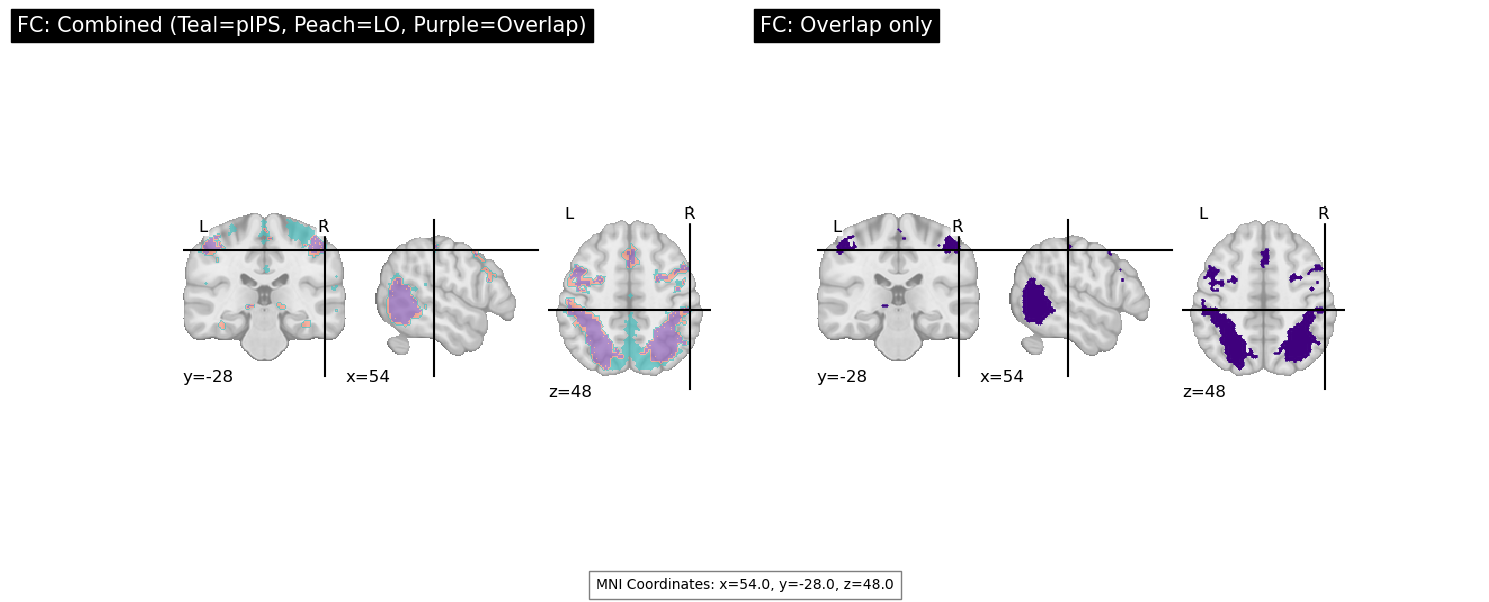

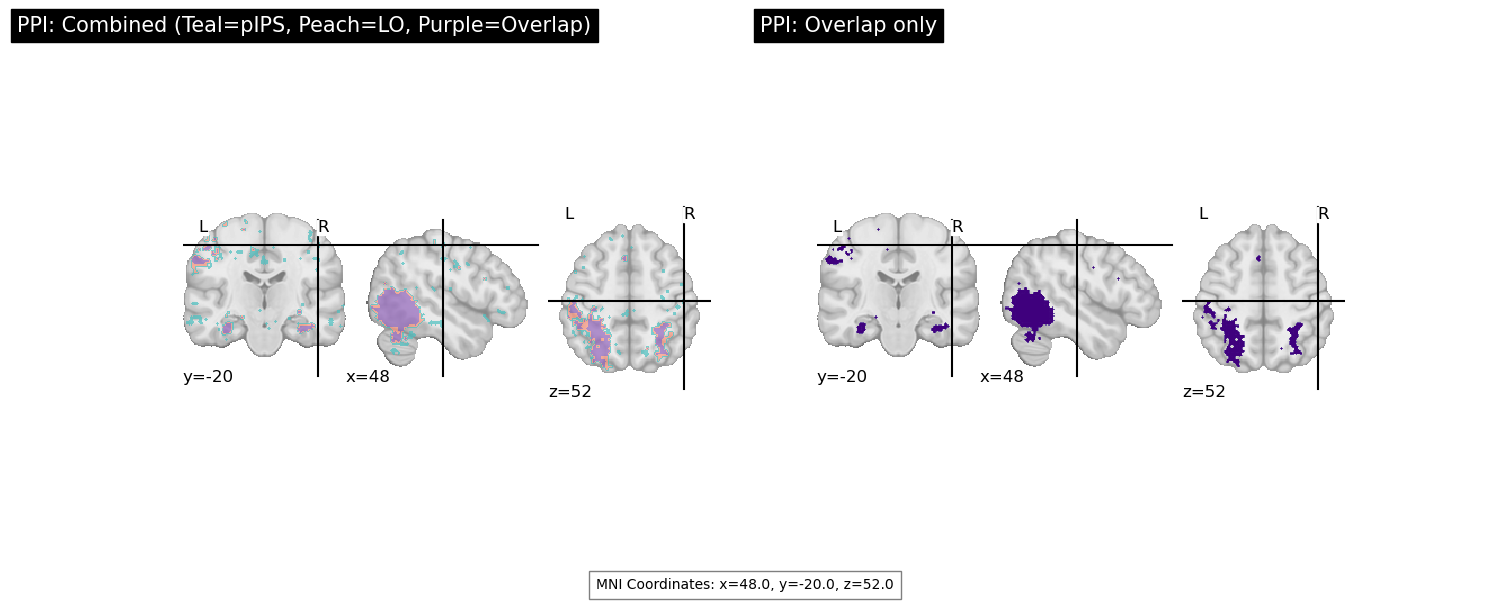

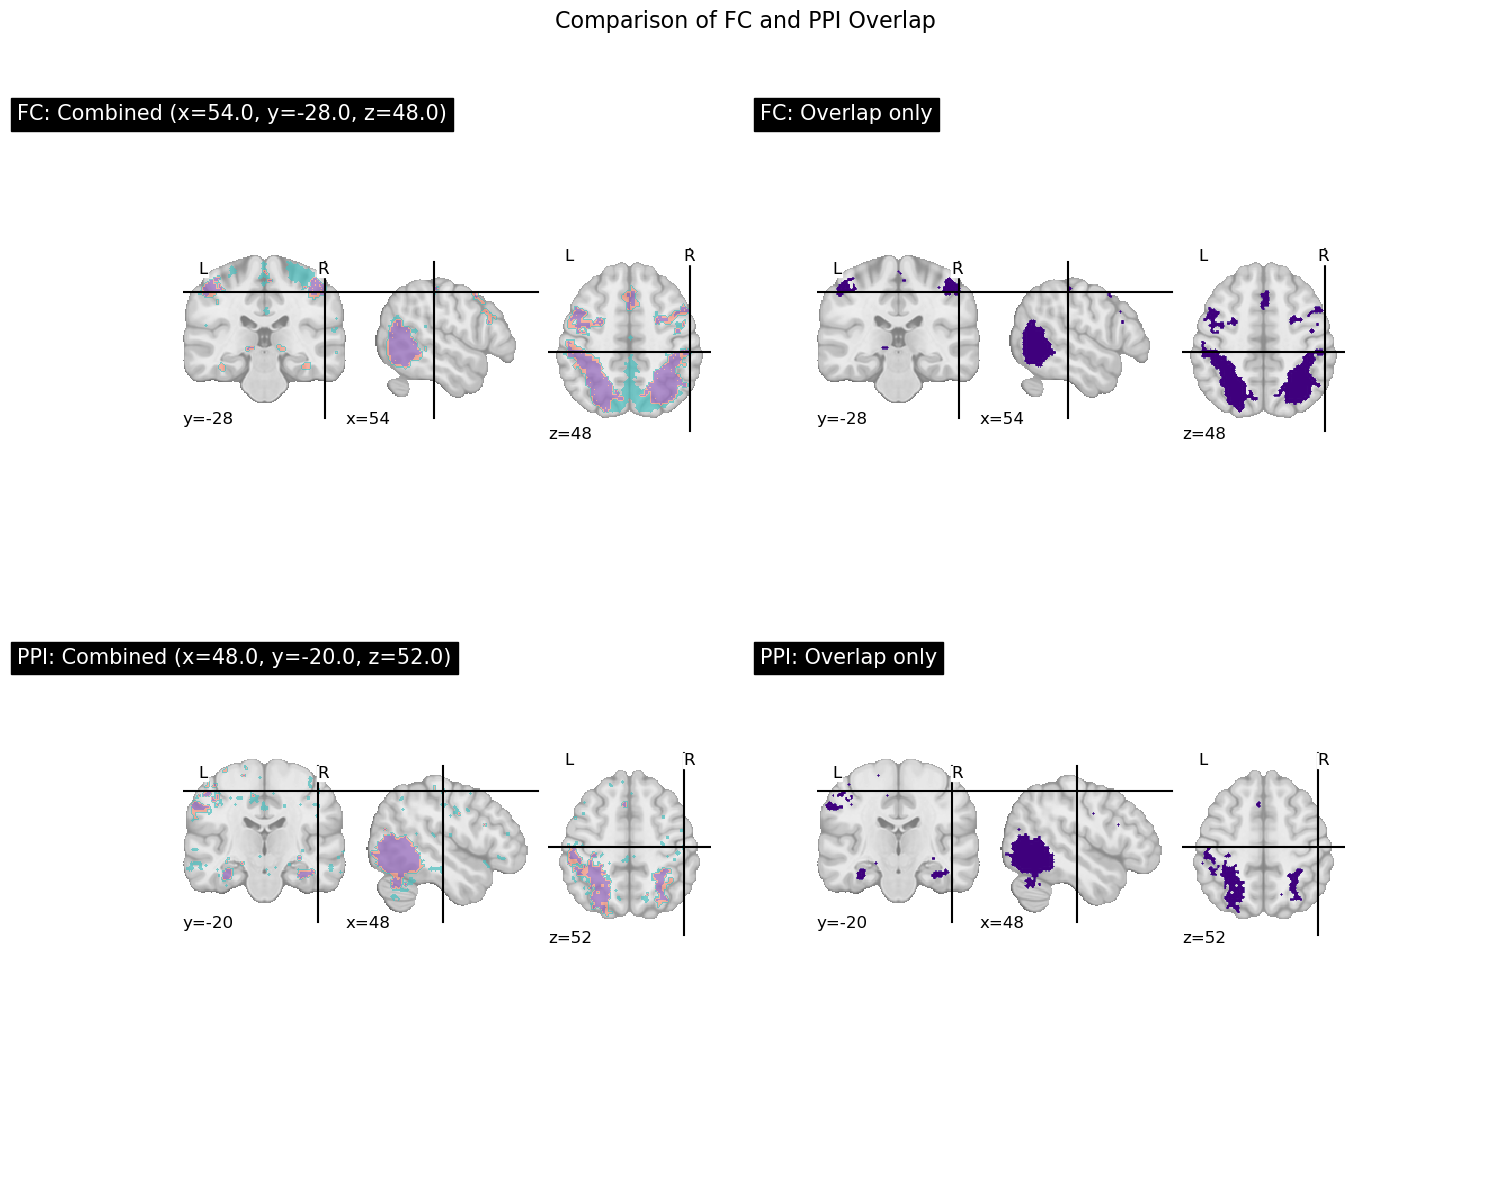

In [ ]:
# Visualize overlap - FC and PPI
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn import datasets
from nilearn.image import resample_to_img
from matplotlib.colors import ListedColormap

# Define study directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
group_out_dir = f'{results_dir}/group_averages'

def find_peak_activation(img_data, affine):
    """
    Find the coordinates of peak activation in dorsal regions.
    
    Parameters:
    -----------
    img_data : numpy.ndarray
        Image data array
    affine : numpy.ndarray
        Affine transformation matrix
    
    Returns:
    --------
    tuple
        (x, y, z) coordinates in MNI space
    """
    # Define dorsal region (z > 40mm in MNI space)
    dorsal_mask = np.zeros_like(img_data, dtype=bool)
    
    for x in range(img_data.shape[0]):
        for y in range(img_data.shape[1]):
            for z in range(img_data.shape[2]):
                mni_coords = nib.affines.apply_affine(affine, [x, y, z])
                if mni_coords[2] > 40:  # z > 40mm (dorsal)
                    dorsal_mask[x, y, z] = True
    
    # Apply mask
    masked_data = img_data * dorsal_mask
    
    # Find peak activation
    if np.max(masked_data) > 0:
        peak_idx = np.unravel_index(np.argmax(masked_data), masked_data.shape)
        peak_mni = nib.affines.apply_affine(affine, peak_idx)
        return tuple(peak_mni)
    else:
        # Default coordinates if no peak found
        return (30, -60, 50)

def main(analysis_type='fc', cut_coords=None):
    """
    Simple visualization of pIPS and LO overlap with optimized coordinates.
    
    Parameters:
    -----------
    analysis_type : str
        Analysis type to visualize ('fc' or 'ppi')
    cut_coords : tuple or None
        (x, y, z) cut coordinates in MNI space, or None to find automatically
    """
    print(f"Visualizing {analysis_type.upper()} analysis...")
    
    # Define colors to match the violin plot
    pips_color = '#4ac0c0'  # Teal for pIPS
    lo_color = '#ff9b83'    # Peach for LO
    overlap_color = '#9467bd'  # Purple for overlap
    
    hemispheres = ['left', 'right']
    
    # Load MNI template
    template = datasets.load_mni152_template(resolution=1)
    
    # Load images for both hemispheres for each ROI
    pips_imgs = []
    lo_imgs = []
    
    for hemi in hemispheres:
        # Define file paths
        pips_img_path = f'{group_out_dir}/pIPS_{hemi}_{analysis_type}_thresh.nii.gz'
        lo_img_path = f'{group_out_dir}/LO_{hemi}_{analysis_type}_thresh.nii.gz'
        
        # Check if files exist
        if not os.path.exists(pips_img_path) or not os.path.exists(lo_img_path):
            print(f"Warning: Files not found for {hemi} hemisphere, {analysis_type}. Skipping.")
            continue
        
        # Load images
        pips_imgs.append(nib.load(pips_img_path))
        lo_imgs.append(nib.load(lo_img_path))
    
    # Skip if we don't have images for both hemispheres
    if len(pips_imgs) != 2 or len(lo_imgs) != 2:
        print(f"Warning: Missing data for one or more hemispheres in {analysis_type}. Skipping.")
        return
    
    # Create averaged hemisphere maps
    # Get the affine and header from the first image
    affine = pips_imgs[0].affine
    header = pips_imgs[0].header
    
    # Create average maps for each ROI
    pips_avg_data = (pips_imgs[0].get_fdata() + pips_imgs[1].get_fdata()) / 2
    lo_avg_data = (lo_imgs[0].get_fdata() + lo_imgs[1].get_fdata()) / 2
    
    # Create NIfTI images from the averaged data
    pips_avg_img = nib.Nifti1Image(pips_avg_data, affine, header)
    lo_avg_img = nib.Nifti1Image(lo_avg_data, affine, header)
    
    # Calculate binary maps for computation
    pips_binary = (pips_avg_data > 0).astype(int)
    lo_binary = (lo_avg_data > 0).astype(int)
    
    # Create overlap map (1=pIPS only, 2=LO only, 3=overlap)
    overlap_data = np.zeros_like(pips_binary)
    overlap_data[pips_binary == 1] = 1  # pIPS only
    overlap_data[lo_binary == 1] = 2    # LO only
    overlap_data[(pips_binary == 1) & (lo_binary == 1)] = 3  # Overlap
    
    # Create the overlap-only map as binary (1 where overlap occurs, 0 elsewhere)
    overlap_only_data = np.zeros_like(overlap_data)
    overlap_only_data[(pips_binary == 1) & (lo_binary == 1)] = 1
    
    # Create images
    overlap_img = nib.Nifti1Image(overlap_data, affine, header)
    overlap_only_img = nib.Nifti1Image(overlap_only_data, affine, header)
    
    # Resample images to match template resolution for better visualization
    overlap_resampled = resample_to_img(overlap_img, template)
    overlap_only_resampled = resample_to_img(overlap_only_img, template)
    
    # Find optimal cut coordinates if not provided
    if cut_coords is None:
        # Try to find coordinates based on overlap
        if np.sum(overlap_only_data) > 0:
            cut_coords = find_peak_activation(overlap_only_data, affine)
            print(f"Found optimal coordinates for {analysis_type}: {cut_coords}")
        else:
            # Try to find coordinates based on pIPS
            cut_coords = find_peak_activation(pips_avg_data, affine)
            print(f"Found pIPS coordinates for {analysis_type}: {cut_coords}")
    
    # Create figure with just the two panels
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Custom colormap for overlap visualization using the matching colors
    overlap_cmap = ListedColormap(['#00000000', pips_color, lo_color, overlap_color])
    
    # Plot combined map with overlap (left)
    display1 = plotting.plot_roi(
        roi_img=overlap_resampled,
        bg_img=template,
        display_mode='ortho',
        cut_coords=cut_coords,
        colorbar=False,
        cmap=overlap_cmap,
        title=f'{analysis_type.upper()}: Combined (Teal=pIPS, Peach=LO, Purple=Overlap)',
        axes=axes[0],
        black_bg=False
    )
    
    # Plot overlap-only map (right)
    display2 = plotting.plot_stat_map(
        stat_map_img=overlap_only_resampled,
        bg_img=template,
        display_mode='ortho',
        cut_coords=cut_coords,
        colorbar=False,
        cmap='Purples',  # Using a built-in purple colormap
        threshold=0.5,   # Only show values above 0.5 to ensure binary representation
        vmax=1.0,        # Set max value to 1.0
        title=f'{analysis_type.upper()}: Overlap only',
        axes=axes[1],
        black_bg=False
    )
    
    # Add a text annotation with the coordinates
    plt.figtext(0.5, 0.01, f"MNI Coordinates: x={cut_coords[0]:.1f}, y={cut_coords[1]:.1f}, z={cut_coords[2]:.1f}", 
                ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    
    # Save the figure
    plt.savefig(f'{results_dir}/pIPS_LO_merged_{analysis_type}_overlap_binary.png', dpi=300)
    print(f"Saved {analysis_type.upper()} visualization to: {results_dir}/pIPS_LO_merged_{analysis_type}_overlap_binary.png")
    
    # Calculate overlap statistics
    total_pips_voxels = np.sum(pips_binary)
    total_lo_voxels = np.sum(lo_binary)
    total_overlap_voxels = np.sum(overlap_only_data)
    
    # Calculate Dice coefficient
    if (total_pips_voxels + total_lo_voxels) > 0:
        dice_coef = 2 * total_overlap_voxels / (total_pips_voxels + total_lo_voxels)
    else:
        dice_coef = 0
        
    # Print statistics
    print(f"\nOverlap Statistics for {analysis_type.upper()}:")
    print(f"Total pIPS voxels: {total_pips_voxels}")
    print(f"Total LO voxels: {total_lo_voxels}")
    print(f"Total overlap voxels: {total_overlap_voxels}")
    print(f"Overlap percentage: {total_overlap_voxels/max(1, total_pips_voxels + total_lo_voxels - total_overlap_voxels)*100:.2f}%")
    print(f"Dice coefficient: {dice_coef:.4f}")
    
    return fig, cut_coords

def create_combined_figure(fc_coords, ppi_coords):
    """
    Create a combined figure showing FC and PPI results side by side
    with their respective optimal coordinates.
    
    Parameters:
    -----------
    fc_coords : tuple
        (x, y, z) coordinates for FC visualization
    ppi_coords : tuple
        (x, y, z) coordinates for PPI visualization
    """
    # Define analysis types
    analysis_types = ['fc', 'ppi']
    coords = [fc_coords, ppi_coords]
    
    # Create figure with 2 rows, 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Comparison of FC and PPI Overlap', fontsize=16)
    
    # Define colors
    pips_color = '#4ac0c0'  # Teal for pIPS
    lo_color = '#ff9b83'    # Peach for LO
    overlap_color = '#9467bd'  # Purple for overlap
    
    # Load MNI template
    template = datasets.load_mni152_template(resolution=1)
    
    # Process each analysis type
    for i, analysis_type in enumerate(analysis_types):
        # Load overlap images
        hemispheres = ['left', 'right']
        pips_imgs = []
        lo_imgs = []
        
        for hemi in hemispheres:
            pips_img_path = f'{group_out_dir}/pIPS_{hemi}_{analysis_type}_thresh.nii.gz'
            lo_img_path = f'{group_out_dir}/LO_{hemi}_{analysis_type}_thresh.nii.gz'
            
            if not os.path.exists(pips_img_path) or not os.path.exists(lo_img_path):
                print(f"Warning: Files not found for {hemi} hemisphere, {analysis_type}. Skipping.")
                continue
            
            pips_imgs.append(nib.load(pips_img_path))
            lo_imgs.append(nib.load(lo_img_path))
        
        if len(pips_imgs) != 2 or len(lo_imgs) != 2:
            print(f"Warning: Missing data for {analysis_type}. Skipping.")
            continue
        
        # Create averaged maps
        affine = pips_imgs[0].affine
        header = pips_imgs[0].header
        
        pips_avg_data = (pips_imgs[0].get_fdata() + pips_imgs[1].get_fdata()) / 2
        lo_avg_data = (lo_imgs[0].get_fdata() + lo_imgs[1].get_fdata()) / 2
        
        # Create binary maps
        pips_binary = (pips_avg_data > 0).astype(int)
        lo_binary = (lo_avg_data > 0).astype(int)
        
        # Create overlap map
        overlap_data = np.zeros_like(pips_binary)
        overlap_data[pips_binary == 1] = 1
        overlap_data[lo_binary == 1] = 2
        overlap_data[(pips_binary == 1) & (lo_binary == 1)] = 3
        
        overlap_only_data = np.zeros_like(overlap_data)
        overlap_only_data[(pips_binary == 1) & (lo_binary == 1)] = 1
        
        # Create images
        overlap_img = nib.Nifti1Image(overlap_data, affine, header)
        overlap_only_img = nib.Nifti1Image(overlap_only_data, affine, header)
        
        # Resample images
        overlap_resampled = resample_to_img(overlap_img, template)
        overlap_only_resampled = resample_to_img(overlap_only_img, template)
        
        # Custom colormap
        overlap_cmap = ListedColormap(['#00000000', pips_color, lo_color, overlap_color])
        
        # Plot combined map
        plotting.plot_roi(
            roi_img=overlap_resampled,
            bg_img=template,
            display_mode='ortho',
            cut_coords=coords[i],
            colorbar=False,
            cmap=overlap_cmap,
            title=f'{analysis_type.upper()}: Combined (x={coords[i][0]:.1f}, y={coords[i][1]:.1f}, z={coords[i][2]:.1f})',
            axes=axes[i, 0],
            black_bg=False
        )
        
        # Plot overlap-only map
        plotting.plot_stat_map(
            stat_map_img=overlap_only_resampled,
            bg_img=template,
            display_mode='ortho',
            cut_coords=coords[i],
            colorbar=False,
            cmap='Purples',
            threshold=0.5,
            vmax=1.0,
            title=f'{analysis_type.upper()}: Overlap only',
            axes=axes[i, 1],
            black_bg=False
        )
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'{results_dir}/pIPS_LO_FC_vs_PPI_comparison.png', dpi=300)
    print(f"Saved FC vs PPI comparison to: {results_dir}/pIPS_LO_FC_vs_PPI_comparison.png")
    
    return fig

if __name__ == "__main__":
    # Define custom coordinates (comment out to use automatic detection)
    # fc_custom_coords = (30, -60, 50)  # Example coordinates for FC
    # ppi_custom_coords = (30, -60, 50)  # Example coordinates for PPI
    
    # Generate FC figure with auto-detected coordinates
    fc_fig, fc_coords = main(analysis_type='fc')
    print(f"Created FC overlap visualization at coordinates {fc_coords}")
    
    # Generate PPI figure with auto-detected coordinates
    ppi_fig, ppi_coords = main(analysis_type='ppi')
    print(f"Created PPI overlap visualization at coordinates {ppi_coords}")
    
    # Create combined comparison figure
    compare_fig = create_combined_figure(fc_coords, ppi_coords)
    print("Created combined FC vs PPI comparison visualization")

### Fingerprint Connectivity
##### Ventral - dense subnetwork primarily driven by dorsal network - within a broader object network.



>pIPS has many more significant connections than LO (50 vs 12)
>But the few significant connections that favor LO are similarly strong to those that favor pIPS
>This pattern suggests that pIPS's broader network influence comes primarily from having more connections rather than having stronger individual connections.

In [ ]:
# Merge Atlas
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
roi_dir = f'{base_dir}/roiParcels'
results_dir = f'{base_dir}/results'
group_out_dir = f'{results_dir}/group_averages'
os.makedirs(results_dir, exist_ok=True)

def create_merged_atlas():
    """
    Create a merged atlas where Wang ROIs replace overlapping regions in Schaefer atlas
    """
    print("\n=== Step 1: Creating Merged Atlas ===")
    
    # Load Wang ROIs - pIPS and LO
    roi_files = {
        'pIPS': f'{roi_dir}/pIPS.nii.gz',
        'LO': f'{roi_dir}/LO.nii.gz'
    }
    
    rois = {}
    for roi_name, roi_path in roi_files.items():
        if os.path.exists(roi_path):
            rois[roi_name] = nib.load(roi_path)
            print(f"Loaded {roi_name} ROI")
        else:
            print(f"Error: ROI file {roi_path} not found!")
            return None
    
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(atlas.maps)
    atlas_labels = atlas.labels
    print(f"Loaded Schaefer atlas with {len(atlas_labels)} parcels")
    
    # Get atlas data
    atlas_data = atlas_img.get_fdata()
    modified_atlas_data = atlas_data.copy()
    
    # Create a dictionary to store new labels
    new_labels = list(atlas_labels)
    
    # Assign values for new ROIs (continuing from the end of the Schaefer atlas)
    roi_values = {'pIPS': 201, 'LO': 202}
    overlap_info = {}
    
    # Process each ROI
    for roi_name, roi_img in rois.items():
        # Get ROI data and create mask
        roi_data = roi_img.get_fdata()
        roi_mask = roi_data > 0
        
        # Find overlapping parcels
        overlap_mask = (atlas_data > 0) & roi_mask
        overlapping_labels = np.unique(atlas_data[overlap_mask])
        overlapping_labels = overlapping_labels[overlapping_labels > 0]
        
        # Get number of voxels in overlap
        overlap_voxels = {}
        for label in overlapping_labels:
            label_mask = (atlas_data == label) & roi_mask
            overlap_voxels[int(label)] = np.sum(label_mask)
        
        # Store overlap information
        overlap_info[roi_name] = {
            'overlapping_labels': overlapping_labels.tolist(),
            'overlap_voxels': overlap_voxels
        }
        
        print(f"{roi_name} overlaps with {len(overlapping_labels)} atlas parcels")
        for label, voxels in overlap_voxels.items():
            label_idx = int(label) - 1  # Convert to 0-indexed
            if 0 <= label_idx < len(atlas_labels):
                label_name = atlas_labels[label_idx]
                label_name = label_name.decode('utf-8') if isinstance(label_name, bytes) else str(label_name)
                print(f"  Label {label} ({label_name}): {voxels} voxels")
        
        # Remove overlapping parcels from the atlas
        for label in overlapping_labels:
            label_mask = (modified_atlas_data == label) & roi_mask
            modified_atlas_data[label_mask] = 0
        
        # Add ROI with new label
        modified_atlas_data[roi_mask] = roi_values[roi_name]
        
        # Add new label name
        new_labels.append(f"Wang_{roi_name}")
    
    # Create the modified atlas
    modified_atlas_img = nib.Nifti1Image(modified_atlas_data, atlas_img.affine, atlas_img.header)
    merged_atlas_file = f'{results_dir}/schaefer_wang_merged.nii.gz'
    nib.save(modified_atlas_img, merged_atlas_file)
    print(f"Saved merged atlas to: {merged_atlas_file}")
    
    # Save new labels array
    np.save(f'{results_dir}/merged_atlas_labels.npy', new_labels)
    
    # Return atlas information
    return {
        'atlas_img': atlas_img,
        'merged_atlas_img': modified_atlas_img,
        'atlas_labels': atlas_labels,
        'merged_labels': new_labels,
        'roi_values': roi_values,
        'overlap_info': overlap_info
    }

# Run the full analysis
if __name__ == "__main__":
    create_merged_atlas()


=== Step 1: Creating Merged Atlas ===
Loaded pIPS ROI
Loaded LO ROI
Loaded Schaefer atlas with 200 parcels
pIPS overlaps with 28 atlas parcels
  Label 9 (7Networks_LH_Vis_9): 7 voxels
  Label 11 (7Networks_LH_Vis_11): 159 voxels
  Label 12 (7Networks_LH_Vis_12): 2 voxels
  Label 13 (7Networks_LH_Vis_13): 381 voxels
  Label 14 (7Networks_LH_Vis_14): 528 voxels
  Label 33 (7Networks_LH_DorsAttn_Post_3): 554 voxels
  Label 36 (7Networks_LH_DorsAttn_Post_6): 4 voxels
  Label 37 (7Networks_LH_DorsAttn_Post_7): 567 voxels
  Label 38 (7Networks_LH_DorsAttn_Post_8): 64 voxels
  Label 39 (7Networks_LH_DorsAttn_Post_9): 99 voxels
  Label 40 (7Networks_LH_DorsAttn_Post_10): 15 voxels
  Label 62 (7Networks_LH_Cont_Par_2): 269 voxels
  Label 71 (7Networks_LH_Cont_pCun_1): 247 voxels
  Label 80 (7Networks_LH_Default_Par_2): 436 voxels
  Label 82 (7Networks_LH_Default_Par_4): 85 voxels
  Label 99 (7Networks_LH_Default_pCunPCC_4): 5 voxels
  Label 111 (7Networks_RH_Vis_11): 119 voxels
  Label 112 (7N

In [26]:
# Regional Brain Connectivity Analysis Part 1: Analysis and CSV Export
# Description: Analysis of functional connectivity (FC) and psychophysiological interaction (PPI)
#              between parietal IPS and lateral occipital regions with CSV export

import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from sklearn.utils import resample

# Define study paths
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/connectivity_comparison'
os.makedirs(output_dir, exist_ok=True)

def analyze_connectivity_and_save_results(analysis_type='fc'):
    """Analyze connectivity and save results as CSV using merged atlas"""
    print(f"\n{'='*80}")
    print(f"ANALYZING {analysis_type.upper()} CONNECTIVITY AND SAVING RESULTS")
    print(f"{'='*80}")
    
    # Load merged atlas instead of fetching standard Schaefer atlas
    merged_atlas_file = f'{results_dir}/schaefer_wang_merged.nii.gz'
    merged_labels_file = f'{results_dir}/merged_atlas_labels.npy'
    
    if not os.path.exists(merged_atlas_file) or not os.path.exists(merged_labels_file):
        print("Error: Merged atlas files not found. Please run merge_atlas.py first.")
        return None
    
    atlas_img = nib.load(merged_atlas_file)
    atlas_labels = np.load(merged_labels_file, allow_pickle=True)
    
    print(f"Loaded merged atlas with {len(atlas_labels)} parcels")
    
    # Load subject info
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    
    # Exclude sub-084 as specified
    if 'sub-084' in subjects:
        subjects.remove('sub-084')
        print("Excluded sub-084 from analysis")
        
    print(f"Found {len(subjects)} control subjects")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    
    # Setup atlas masker
    masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)
    
    # Load and process subject data
    subject_data = []
    for sub in subjects:
        sub_conn = {}
        
        for roi in rois:
            # Initialize arrays to hold combined data
            combined_data = None
            hemi_count = 0
            
            for hemisphere in hemispheres:
                fc_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemisphere}_loc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(fc_file):
                    try:
                        # Load the FC map
                        fc_img = nib.load(fc_file)
                        
                        # Extract ROI values using atlas
                        fc_values = masker.fit_transform(fc_img)[0]
                        
                        # Add to combined data
                        if combined_data is None:
                            combined_data = fc_values
                        else:
                            combined_data += fc_values
                        
                        hemi_count += 1
                    except Exception as e:
                        print(f"Error processing {fc_file}: {e}")
            
            # Average the data if we have at least one hemisphere
            if hemi_count > 0:
                sub_conn[roi] = combined_data / hemi_count
        
        # Only include subjects with both ROIs
        if len(sub_conn) == len(rois):
            subject_data.append(sub_conn)
    
    n_valid_subjects = len(subject_data)
    print(f"Successfully loaded data for {n_valid_subjects} subjects")
    
    if n_valid_subjects < 3:
        print("Not enough valid subjects. Analysis cannot proceed.")
        return None
    
    # Initialize arrays for analysis
    n_rois = len(atlas_labels)
    pips_fc = np.zeros((n_valid_subjects, n_rois))
    lo_fc = np.zeros((n_valid_subjects, n_rois))
    
    # Fill arrays with connectivity data
    for i, subj_data in enumerate(subject_data):
        pips_fc[i, :] = subj_data['pIPS']
        lo_fc[i, :] = subj_data['LO']
    
    # Calculate connectivity vector correlation for each subject
    vector_correlations = np.zeros(n_valid_subjects)
    for i in range(n_valid_subjects):
        vector_correlations[i] = np.corrcoef(pips_fc[i, :], lo_fc[i, :])[0, 1]
    
    print(f"Mean connectivity vector correlation: {np.mean(vector_correlations):.3f} ± {np.std(vector_correlations):.3f}")
    
    # Calculate mean connectivity profiles
    mean_pips = np.mean(pips_fc, axis=0)
    mean_lo = np.mean(lo_fc, axis=0)
    
    # Remove self-connectivity
    # Get indices for Wang ROIs in the merged atlas
    wang_pips_idx = next((i for i, label in enumerate(atlas_labels) if 'Wang_pIPS' in str(label)), None)
    wang_lo_idx = next((i for i, label in enumerate(atlas_labels) if 'Wang_LO' in str(label)), None)
    
    # Print which indices are being excluded
    if wang_pips_idx is not None:
        print(f"Excluding Wang_pIPS (index {wang_pips_idx}) from connectivity analysis")
    if wang_lo_idx is not None:
        print(f"Excluding Wang_LO (index {wang_lo_idx}) from connectivity analysis")
    
    # Create mask for non-self connections (all True except at Wang ROI indices)
    mask = np.ones(len(atlas_labels), dtype=bool)
    if wang_pips_idx is not None:
        mask[wang_pips_idx] = False
    if wang_lo_idx is not None:
        mask[wang_lo_idx] = False
    
    # Apply mask to connectivity data
    pips_fc_masked = pips_fc[:, mask]
    lo_fc_masked = lo_fc[:, mask]
    
    # Get the masked atlas labels
    atlas_labels_masked = [label for i, label in enumerate(atlas_labels) if mask[i]]
    
    # Update mean connectivity with masked data
    mean_pips_masked = np.mean(pips_fc_masked, axis=0)
    mean_lo_masked = np.mean(lo_fc_masked, axis=0)
    
    # Get the new number of ROIs after masking
    n_masked_rois = np.sum(mask)
    print(f"Analyzing {n_masked_rois} ROIs after excluding Wang ROIs")
    
    # Calculate difference profile with masked data
    diff_profile = mean_pips_masked - mean_lo_masked
    abs_diff_profile = np.abs(diff_profile)
    
    # Run bootstrap analysis with masked data
    print("Performing bootstrap analysis...")
    n_boots = 10000
    boot_diffs = np.zeros((n_boots, n_masked_rois))
    
    for i in range(n_boots):
        # Resample subjects with replacement
        boot_idx = resample(range(n_valid_subjects), replace=True, n_samples=n_valid_subjects)
        
        # Calculate mean difference for this bootstrap sample
        boot_pips = np.mean(pips_fc_masked[boot_idx, :], axis=0)
        boot_lo = np.mean(lo_fc_masked[boot_idx, :], axis=0)
        boot_diffs[i, :] = boot_pips - boot_lo
    
    # Calculate confidence intervals
    ci_lower = np.percentile(boot_diffs, 2.5, axis=0)
    ci_upper = np.percentile(boot_diffs, 97.5, axis=0)
    
    # Identify significant differences (95% CI doesn't cross zero)
    sig_boot = (ci_lower > 0) | (ci_upper < 0)
    sig_boot_count = np.sum(sig_boot)
    print(f"Found {sig_boot_count} ROIs with significant differences via bootstrap")
    
    # Leave-One-Out Cross-Validation for reliability
    print("Performing Leave-One-Out Cross-Validation...")
    loo_reliability = np.zeros(n_masked_rois)
    
    for left_out in range(n_valid_subjects):
        # Create the training set (all subjects except the left out one)
        train_idx = list(range(n_valid_subjects))
        train_idx.remove(left_out)
        
        # Calculate mean training differences
        train_diff = np.mean(pips_fc_masked[train_idx, :] - lo_fc_masked[train_idx, :], axis=0)
        
        # Test on left out subject
        test_diff = pips_fc_masked[left_out, :] - lo_fc_masked[left_out, :]
        
        # Calculate consistency of signs between training and test
        loo_reliability += (np.sign(train_diff) == np.sign(test_diff)).astype(float)
    
    # Convert to proportion of consistent predictions
    loo_reliability = loo_reliability / n_valid_subjects
    
    # Set threshold at 75% consistency
    loo_threshold = 0.75
    sig_loo = loo_reliability >= loo_threshold
    sig_loo_count = np.sum(sig_loo)
    
    print(f"LOO reliability threshold: {loo_threshold:.3f}")
    print(f"Found {sig_loo_count} ROIs with high reliability via LOO")
    
    # Combine significance
    sig_combined = sig_boot & sig_loo
    sig_combined_count = np.sum(sig_combined)
    print(f"Found {sig_combined_count} ROIs significant with combined criteria")
    
    # Helper function to get ROI name
    def get_roi_name(roi_id):
        try:
            idx = int(roi_id) - 1
            if 0 <= idx < len(atlas_labels):
                label = atlas_labels[idx]
                if isinstance(label, bytes):
                    label = label.decode('utf-8')
                return label
        except:
            pass
        return f"ROI_{roi_id}"
    
    # Create a map from masked indices to original atlas indices
    original_indices = np.where(mask)[0]
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'ROI_ID': original_indices + 1,  # Convert to 1-based indexing
        'ROI_Name': [get_roi_name(i+1) for i in original_indices],
        'pIPS_Connectivity': mean_pips_masked,
        'LO_Connectivity': mean_lo_masked,
        'Difference': diff_profile,
        'Abs_Difference': abs_diff_profile,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper,
        'LOO_Reliability': loo_reliability,
        'Bootstrap_Significant': sig_boot,
        'LOO_Significant': sig_loo,
        'Combined_Significant': sig_combined,
        'Direction': np.where(diff_profile > 0, 'pIPS > LO', 'LO > pIPS')
    })
    
    # Save results to CSV
    csv_path = f'{output_dir}/bilateral_{analysis_type}_connectivity_fingerprint_results.csv'
    results_df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")
    
    # Create roi_data dictionary for visualization
    roi_data = {
        'mean_pips': mean_pips_masked,
        'mean_lo': mean_lo_masked,
        'diff_profile': diff_profile,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'sig_combined': sig_combined
    }
    
    return results_df, roi_data

# Run analyses for both FC and PPI
print("\nRunning FC and PPI analyses and saving results...")
print("\n----- FC ANALYSIS -----")
fc_results, fc_data = analyze_connectivity_and_save_results(analysis_type='fc')
print("\n----- PPI ANALYSIS -----")
ppi_results, ppi_data = analyze_connectivity_and_save_results(analysis_type='ppi')

print("\nAnalyses complete - results were saved to disk.")


Running FC and PPI analyses and saving results...

----- FC ANALYSIS -----

ANALYZING FC CONNECTIVITY AND SAVING RESULTS
Loaded merged atlas with 202 parcels
Excluded sub-084 from analysis
Found 18 control subjects
Successfully loaded data for 18 subjects
Mean connectivity vector correlation: 0.724 ± 0.222
Excluding Wang_pIPS (index 200) from connectivity analysis
Excluding Wang_LO (index 201) from connectivity analysis
Analyzing 200 ROIs after excluding Wang ROIs
Performing bootstrap analysis...
Found 94 ROIs with significant differences via bootstrap
Performing Leave-One-Out Cross-Validation...
LOO reliability threshold: 0.750
Found 67 ROIs with high reliability via LOO
Found 60 ROIs significant with combined criteria
Results saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/bilateral_fc_connectivity_fingerprint_results.csv

----- PPI ANALYSIS -----

ANALYZING PPI CONNECTIVITY AND SAVING RESULTS
Loaded merged atlas with 202 parcels
Excluded sub-084 from ana


Creating brain connectivity visualizations from saved CSV data...

CREATING FC BRAIN CONNECTIVITY FIGURE FROM SAVED DATA
Loaded merged atlas with 202 regions
Loaded FC data with 200 ROIs
Found 60 significant ROIs

Creating brain connectivity visualization...


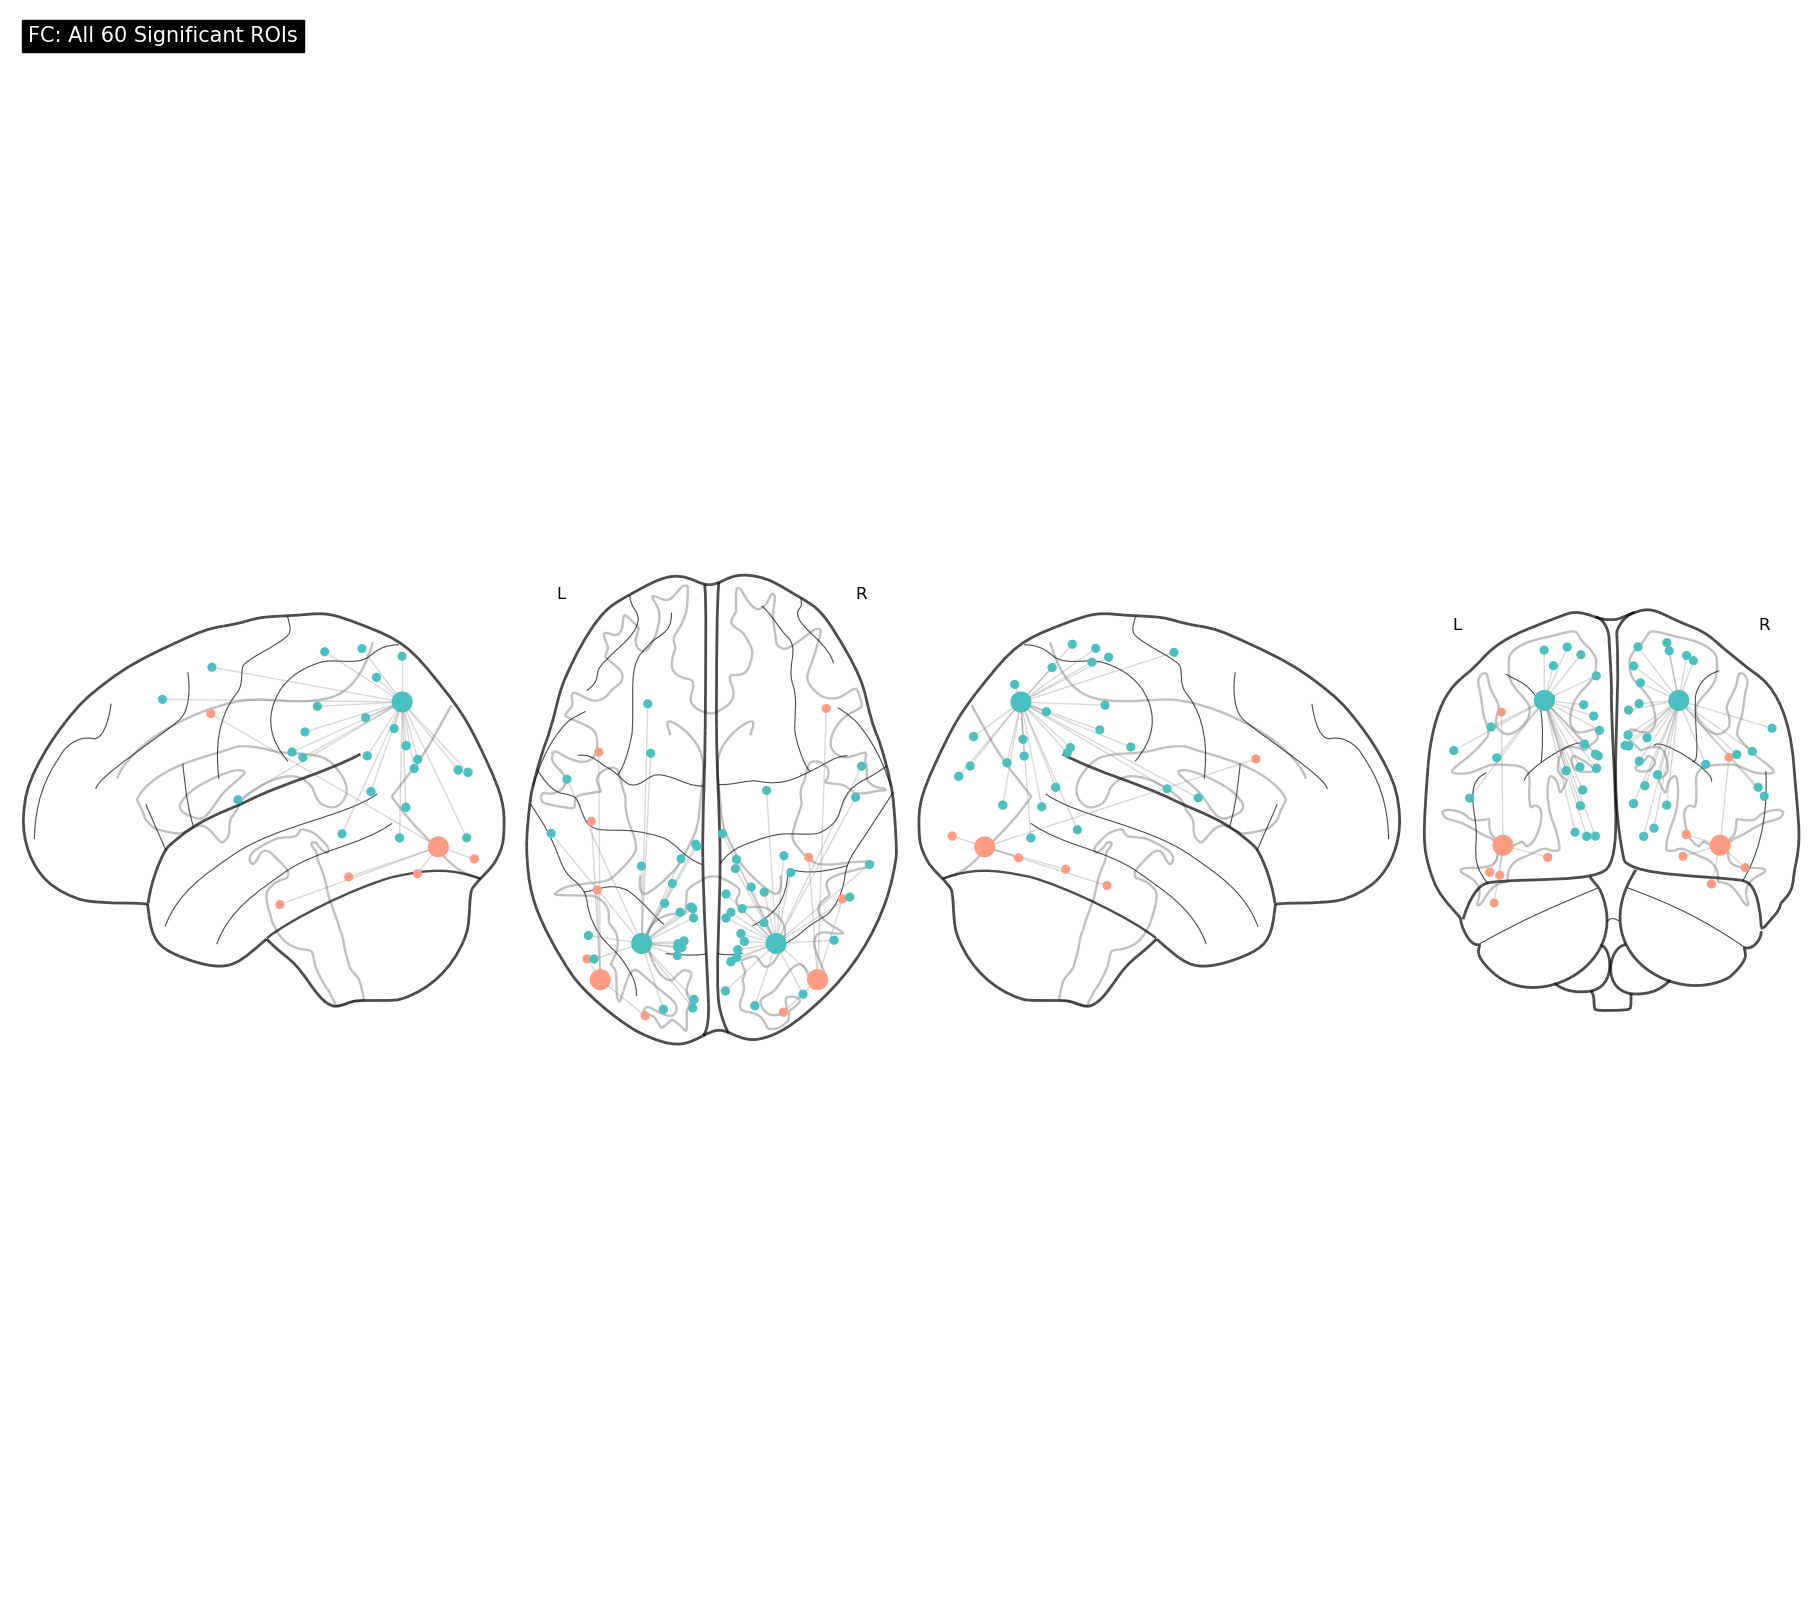

Brain network visualization complete for fc
Showing 60 significant ROIs connected to pIPS and LO seed regions
Figure saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/fc_brain_connectivity.png

CREATING PPI BRAIN CONNECTIVITY FIGURE FROM SAVED DATA
Loaded merged atlas with 202 regions
Loaded PPI data with 200 ROIs
Found 19 significant ROIs

Creating brain connectivity visualization...


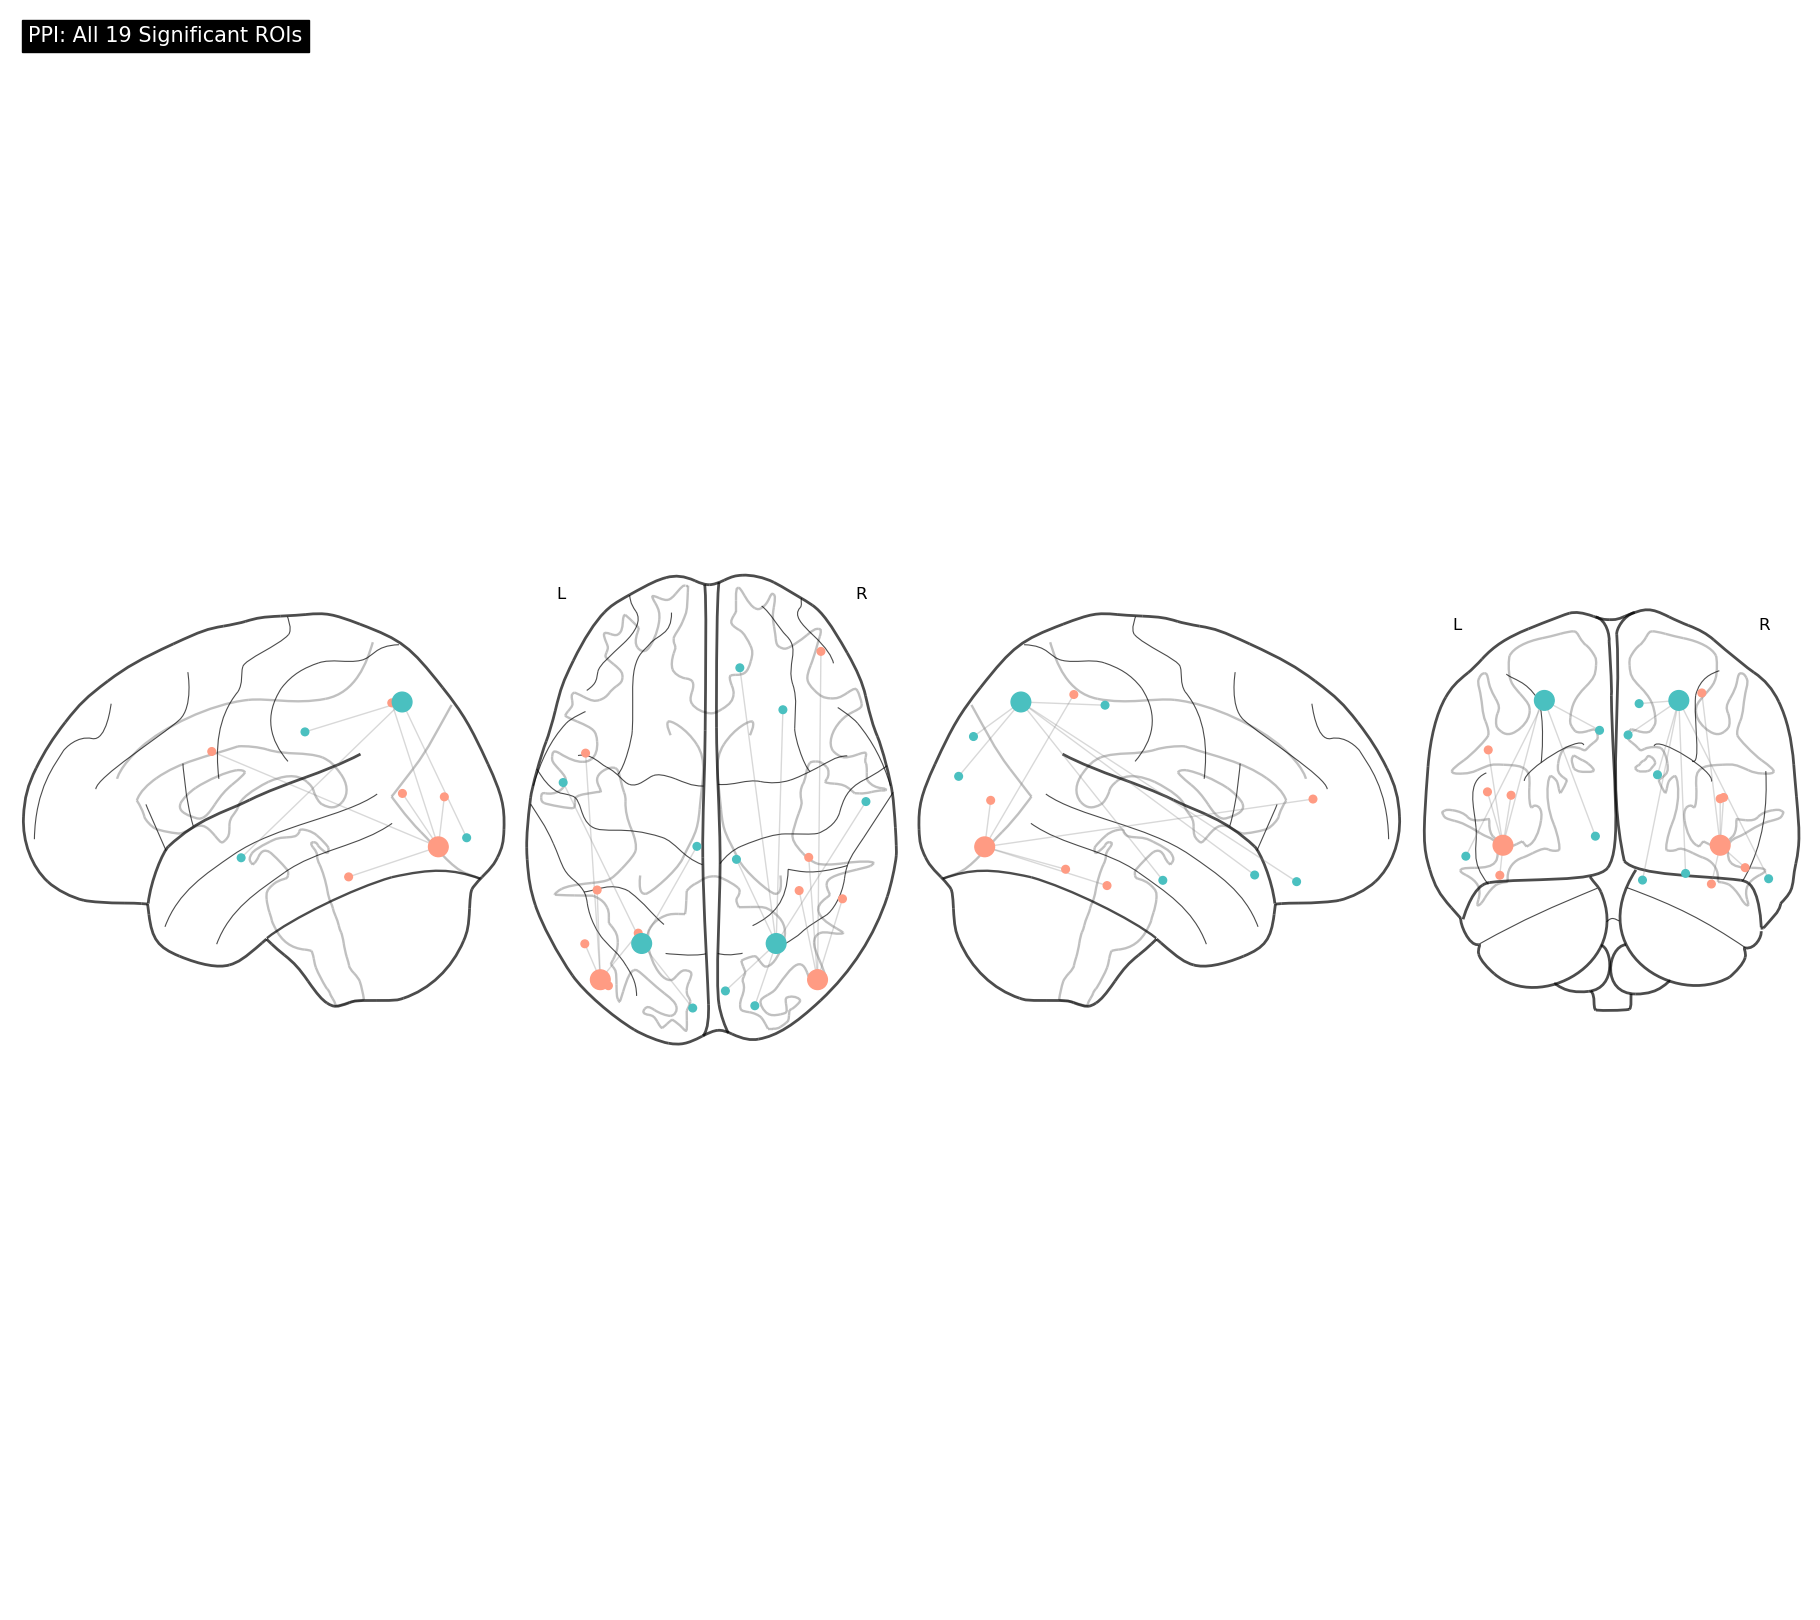

Brain network visualization complete for ppi
Showing 19 significant ROIs connected to pIPS and LO seed regions
Figure saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/ppi_brain_connectivity.png

Visualizations complete - figures were saved to disk.


In [27]:
# FC + PPI Brain Connectivity Figures using saved CSV data and merged atlas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib

# Define paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
connectivity_dir = f'{results_dir}/connectivity_comparison'

def visualize_brain_connectivity(analysis_type='fc'):
    """Create brain visualization for specified data type using saved CSV results"""
    print(f"\n{'='*80}")
    print(f"CREATING {analysis_type.upper()} BRAIN CONNECTIVITY FIGURE FROM SAVED DATA")
    print(f"{'='*80}")
    
    # Load merged atlas instead of the standard Schaefer atlas
    merged_atlas_file = f'{results_dir}/schaefer_wang_merged.nii.gz'
    merged_labels_file = f'{results_dir}/merged_atlas_labels.npy'
    
    if not os.path.exists(merged_atlas_file) or not os.path.exists(merged_labels_file):
        print("Error: Merged atlas files not found. Please run merge_atlas.py first.")
        return None
    
    # Load merged atlas
    atlas_img = nib.load(merged_atlas_file)
    atlas_labels = np.load(merged_labels_file, allow_pickle=True)
    print(f"Loaded merged atlas with {len(atlas_labels)} regions")
    
    # Load saved connectivity results
    csv_path = f'{connectivity_dir}/bilateral_{analysis_type}_connectivity_fingerprint_results.csv'
    if not os.path.exists(csv_path):
        print(f"Error: Could not find {analysis_type.upper()} results at {csv_path}")
        return None
    
    # Load the data
    results_df = pd.read_csv(csv_path)
    print(f"Loaded {analysis_type.upper()} data with {len(results_df)} ROIs")
    
    # Filter to significant regions according to the combined criteria
    sig_df = results_df[results_df['Combined_Significant'] == True].copy()
    sig_df['Hemisphere'] = sig_df['ROI_Name'].apply(lambda x: 'L' if 'LH' in x else 'R' if 'RH' in x else 'X')
    
    print(f"Found {len(sig_df)} significant ROIs")
    
    # ==================================
    # BRAIN NETWORK VISUALIZATION
    # ==================================
    print("\nCreating brain connectivity visualization...")
    
    if len(sig_df) > 0:
        # Get coordinates for all ROIs from the merged atlas
        all_coords = plotting.find_parcellation_cut_coords(atlas_img)
        
        # Prepare node properties for significant ROIs
        sig_coords = []
        sig_colors = []
        sig_sizes = []
        sig_labels = []
        
        for _, row in sig_df.iterrows():
            roi_idx = row['ROI_ID'] - 1  # Convert to 0-based index
            sig_coords.append(all_coords[roi_idx])
            sig_colors.append('#4ac0c0' if row['Difference'] > 0 else '#ff9b83')
            sig_sizes.append(abs(row['Difference']) * 40 + 30)
            sig_labels.append(f"{row['ROI_ID']}\n{row['ROI_Name'].split('_')[-1]}")
        
        # Add seed nodes
        seed_coords = [
            [-26, -68, 48], [26, -68, 48],  # pIPS L/R
            [-42, -82, -8], [42, -82, -8]    # LO L/R
        ]
        all_coords = sig_coords + seed_coords
        all_colors = sig_colors + ['#4ac0c0', '#4ac0c0', '#ff9b83', '#ff9b83']
        all_sizes = sig_sizes + [200, 200, 200, 200]
        
        # Create adjacency matrix
        adjacency = np.zeros((len(all_coords), len(all_coords)))
        for i, row in enumerate(sig_df.itertuples()):
            tgt_offset = 0 if row.Difference > 0 else 2
            tgt_idx = len(sig_coords) + tgt_offset + (0 if row.Hemisphere == 'L' else 1)
            adjacency[i, tgt_idx] = adjacency[tgt_idx, i] = 1
        
        # Create network plot
        fig = plt.figure(figsize=(18, 16))
        plotting.plot_connectome(
            adjacency, all_coords,
            node_color=all_colors,
            node_size=all_sizes,
            edge_kwargs={'color': 'gray', 'alpha': 0.3, 'linewidth': 1.0},
            display_mode='lzry',
            title=f'{analysis_type.upper()}: All {len(sig_df)} Significant ROIs',
            figure=fig
        )
        
        # Save the figure
        output_path = f'{connectivity_dir}/{analysis_type}_brain_connectivity.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Brain network visualization complete for {analysis_type}")
        print(f"Showing {len(sig_df)} significant ROIs connected to pIPS and LO seed regions")
        print(f"Figure saved to {output_path}")
    else:
        print(f"No significant ROIs found for {analysis_type}. Cannot create brain visualization.")
    
    return sig_df

# Run visualizations for both FC and PPI
print("\nCreating brain connectivity visualizations from saved CSV data...")
fc_results = visualize_brain_connectivity(analysis_type='fc')
ppi_results = visualize_brain_connectivity(analysis_type='ppi')

print("\nVisualizations complete - figures were saved to disk.")

Loaded merged atlas labels with 202 regions
Loaded FC results from /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/bilateral_fc_connectivity_fingerprint_results.csv

CREATING FC ANATOMICAL ORGANIZATION VISUALIZATION


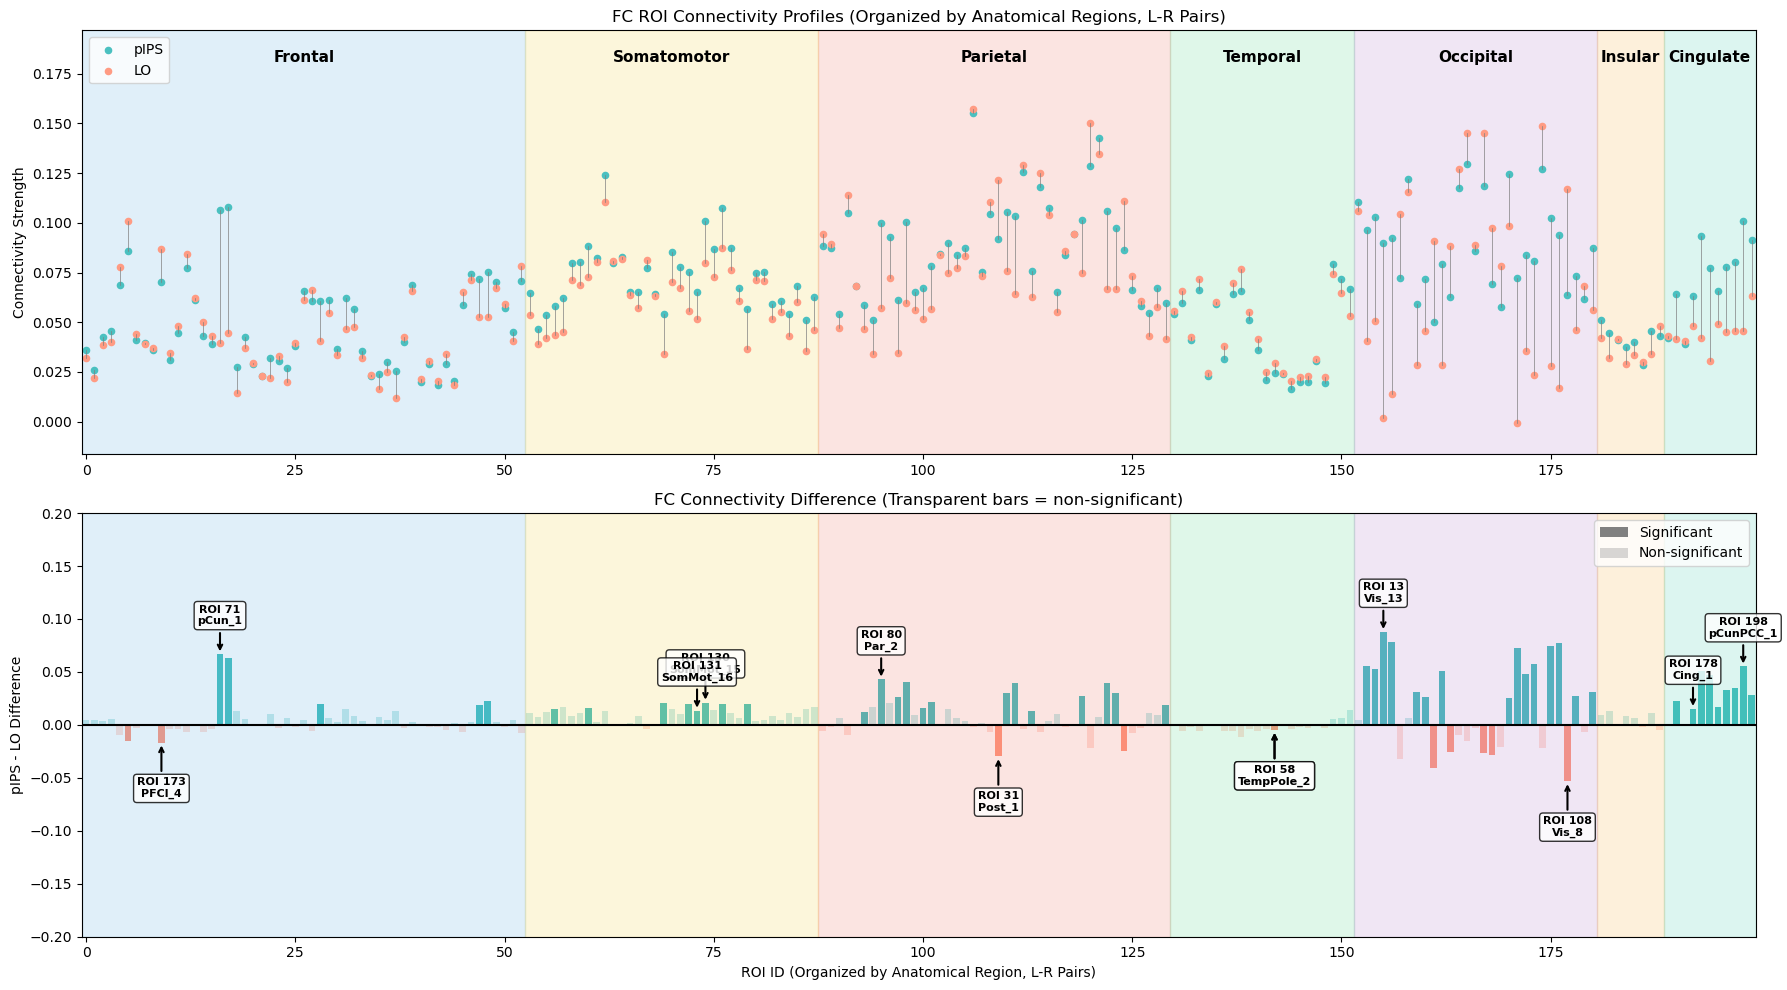

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/fc_anatomical_organization.png

FC significant peak and bottom ROIs by anatomical lobe:

Cingulate Lobe:
  Peak (pIPS > LO): ROI 198 (pCunPCC_1), Diff = 0.055
  Bottom (LO > pIPS): ROI 178 (Cing_1), Diff = 0.015

Frontal Lobe:
  Peak (pIPS > LO): ROI 71 (pCun_1), Diff = 0.067
  Bottom (LO > pIPS): ROI 173 (PFCl_4), Diff = -0.017

Occipital Lobe:
  Peak (pIPS > LO): ROI 13 (Vis_13), Diff = 0.088
  Bottom (LO > pIPS): ROI 108 (Vis_8), Diff = -0.053

Parietal Lobe:
  Peak (pIPS > LO): ROI 80 (Par_2), Diff = 0.043
  Bottom (LO > pIPS): ROI 31 (Post_1), Diff = -0.030

Somatomotor Lobe:
  Peak (pIPS > LO): ROI 130 (SomMot_15), Diff = 0.021
  Bottom (LO > pIPS): ROI 131 (SomMot_16), Diff = 0.014

Temporal Lobe:
  Peak (pIPS > LO): ROI 58 (TempPole_2), Diff = -0.005
  Bottom (LO > pIPS): ROI 58 (TempPole_2), Diff = -0.005
Loaded PPI results from /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/

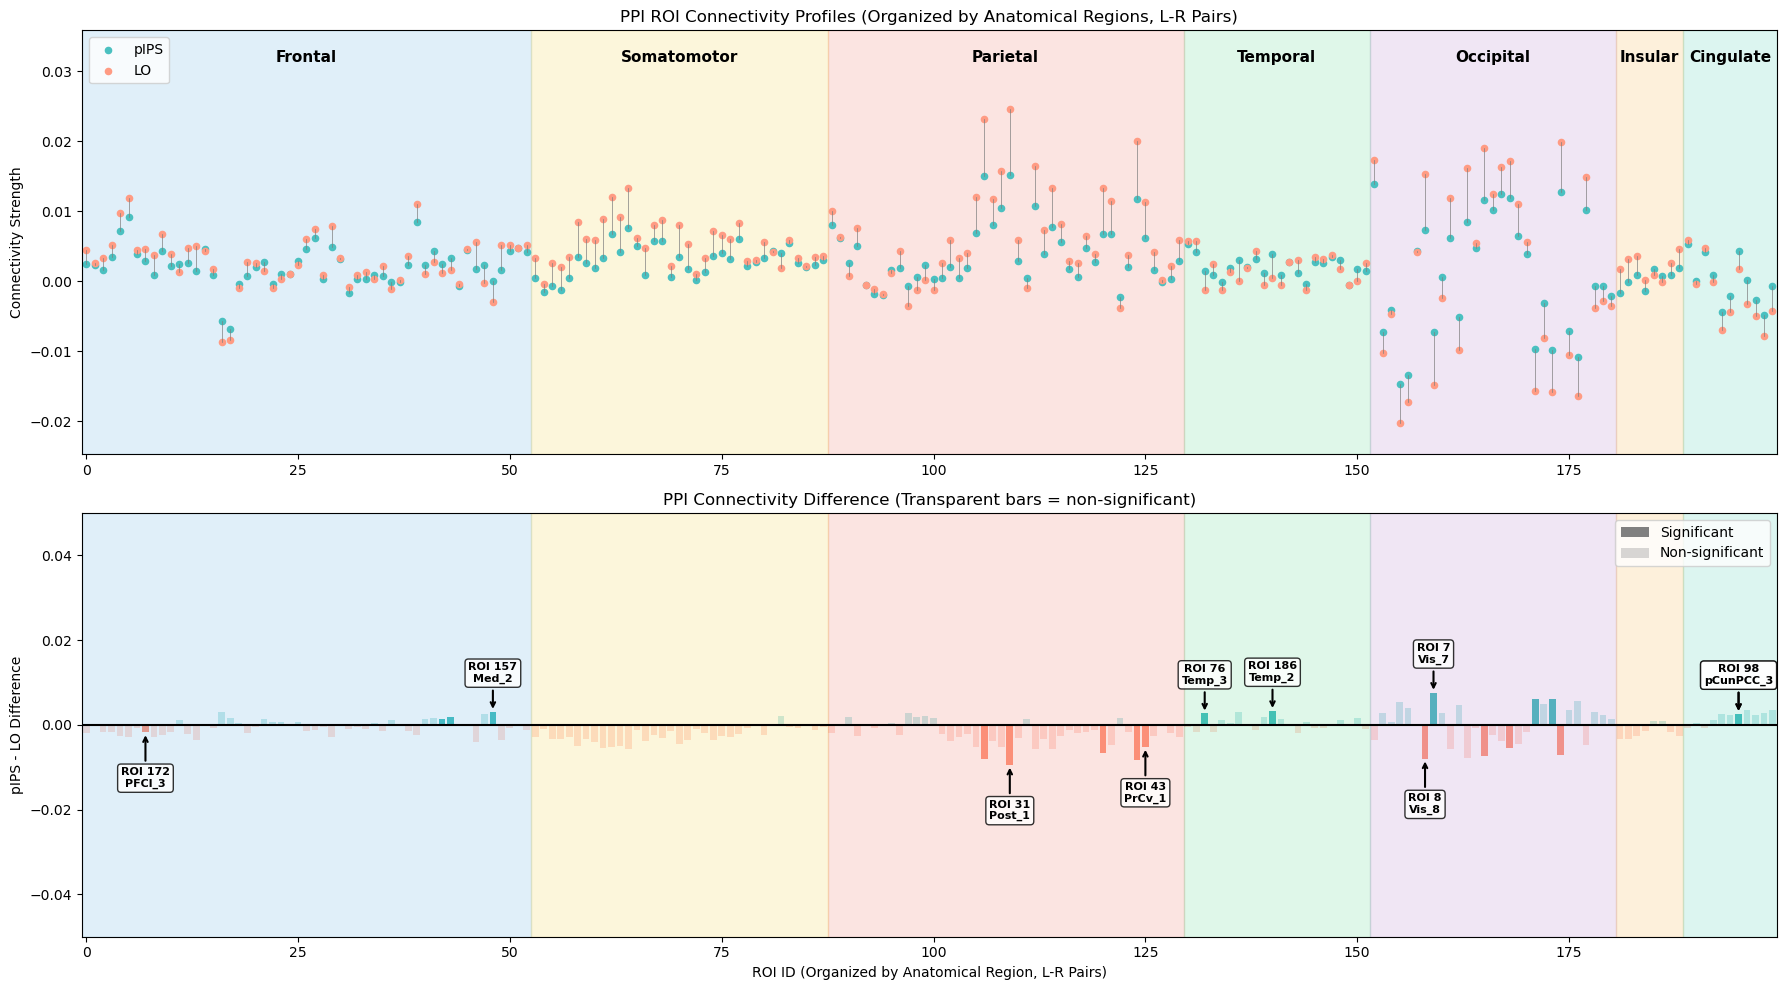

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/ppi_anatomical_organization.png

PPI significant peak and bottom ROIs by anatomical lobe:

Cingulate Lobe:
  Peak (pIPS > LO): ROI 98 (pCunPCC_3), Diff = 0.003
  Bottom (LO > pIPS): ROI 98 (pCunPCC_3), Diff = 0.003

Frontal Lobe:
  Peak (pIPS > LO): ROI 157 (Med_2), Diff = 0.003
  Bottom (LO > pIPS): ROI 172 (PFCl_3), Diff = -0.002

Occipital Lobe:
  Peak (pIPS > LO): ROI 7 (Vis_7), Diff = 0.008
  Bottom (LO > pIPS): ROI 8 (Vis_8), Diff = -0.008

Parietal Lobe:
  Peak (pIPS > LO): ROI 43 (PrCv_1), Diff = -0.005
  Bottom (LO > pIPS): ROI 31 (Post_1), Diff = -0.009

Temporal Lobe:
  Peak (pIPS > LO): ROI 186 (Temp_2), Diff = 0.003
  Bottom (LO > pIPS): ROI 76 (Temp_3), Diff = 0.003


In [28]:
# Regional Brain Connectivity Analysis Part 2: Visualization
# Description: Visualization of functional connectivity (FC) and psychophysiological interaction (PPI)
#              between parietal IPS and lateral occipital regions organized by anatomical location

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from matplotlib.patches import Patch

# Define paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/connectivity_comparison'

def visualize_anatomical_organization(results_df, roi_data, analysis_type='fc'):
    """Create anatomical organization visualization"""
    print(f"\n{'='*80}")
    print(f"CREATING {analysis_type.upper()} ANATOMICAL ORGANIZATION VISUALIZATION")
    print(f"{'='*80}")
    
    # Extract data from parameters
    mean_pips = roi_data['mean_pips']
    mean_lo = roi_data['mean_lo']
    diff_profile = roi_data['diff_profile']
    ci_lower = roi_data['ci_lower']
    ci_upper = roi_data['ci_upper']
    sig_combined = roi_data['sig_combined']
    
    # Function to map ROI names to anatomical lobes
    def map_to_anatomical_lobe(roi_name):
        # Special handling for Wang atlas ROIs
        if 'Wang_pIPS' in roi_name:
            return 'Parietal'
        elif 'Wang_LO' in roi_name:
            return 'Temporal'
        
        # Map Schaefer networks to anatomical regions
        if 'Vis' in roi_name:
            return 'Occipital'
        elif 'SomMot' in roi_name:
            return 'Somatomotor'
        elif 'DorsAttn' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            else:
                return 'Parietal'
        elif 'SalVentAttn' in roi_name:
            if 'Ins' in roi_name:
                return 'Insular'
            elif 'Cing' in roi_name or 'ACC' in roi_name:
                return 'Cingulate'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'Par' in roi_name:
                return 'Parietal'
            else:
                return 'Frontal'
        elif 'Limbic' in roi_name:
            if 'Temp' in roi_name:
                return 'Temporal'
            else:
                return 'Frontal'
        elif 'Cont' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            elif 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        elif 'Default' in roi_name:
            if 'Par' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'PCC' in roi_name or 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        else:
            return 'Other'
    
    # Clean up ROI names for better labeling
    def clean_roi_name(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Handle Wang ROIs
        if 'Wang_' in roi_name:
            return roi_name.replace('Wang_', '')
        
        # Remove common prefixes and suffixes
        cleaned = roi_name.replace('7Networks_', '')
        
        # Extract just the region part, removing hemisphere and network
        parts = cleaned.split('_')
        if len(parts) > 2:
            return parts[-2] + '_' + parts[-1]
        elif len(parts) > 1:
            return parts[-1]
        else:
            return cleaned
    
    # Determine hemisphere and base region for organizing pairs
    def get_hemisphere_and_region(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Determine hemisphere 
        if 'LH' in roi_name:
            hemisphere = 'L'
        elif 'RH' in roi_name:
            hemisphere = 'R'
        else:
            # For Wang ROIs or ROIs without clear hemisphere
            if 'Wang_pIPS' in roi_name or 'Wang_LO' in roi_name:
                hemisphere = 'X'  # Bilateral
            else:
                hemisphere = 'X'  # Unknown
        
        # Extract base region by removing hemisphere and number
        cleaned = roi_name.replace('7Networks_', '')
        cleaned = cleaned.replace('LH_', '').replace('RH_', '')
        
        # Handle Wang ROIs
        if 'Wang_' in cleaned:
            base_region = cleaned.replace('Wang_', '')
        else:
            # Remove trailing numbers which often differentiate regions
            base_region = re.sub(r'_\d+$', '', cleaned)
        
        return hemisphere, base_region
    
    # Add anatomical lobe and hemisphere information to the dataframe
    results_df['Anatomical_Lobe'] = results_df['ROI_Name'].apply(map_to_anatomical_lobe)
    results_df['Clean_Name'] = results_df['ROI_Name'].apply(clean_roi_name)
    
    # Extract hemisphere and base region info
    hemisphere_region = results_df['ROI_Name'].apply(get_hemisphere_and_region)
    results_df['Hemisphere'] = [h for h, r in hemisphere_region]
    results_df['Base_Region'] = [r for h, r in hemisphere_region]
    
    # Define a manual order for anatomical lobes
    lobe_order = [
        'Frontal',
        'Somatomotor',
        'Parietal',
        'Temporal',
        'Occipital',
        'Insular',
        'Cingulate',
        'Other'
    ]
    
    # Create a category for sorting based on the defined order
    lobe_cat = pd.Categorical(results_df['Anatomical_Lobe'], categories=lobe_order, ordered=True)
    results_df['Lobe_Sorted'] = lobe_cat
    
    # Define a consistent color palette for brain lobes
    lobe_colors = {
        'Frontal': '#3498db',     # Blue
        'Somatomotor': '#f1c40f', # Yellow
        'Parietal': '#e74c3c',    # Red
        'Temporal': '#2ecc71',    # Green
        'Occipital': '#9b59b6',   # Purple
        'Insular': '#f39c12',     # Orange
        'Cingulate': '#1abc9c',   # Turquoise
        'Other': '#7f8c8d'        # Gray
    }
    
    # Custom sorting function to group by lobe, then by base region, then by hemisphere (L then R)
    def custom_sort(row):
        lobe_idx = lobe_order.index(row['Anatomical_Lobe']) if row['Anatomical_Lobe'] in lobe_order else 999
        hemi_idx = 0 if row['Hemisphere'] == 'L' else 1 if row['Hemisphere'] == 'R' else 2
        return (lobe_idx, row['Base_Region'], hemi_idx)
    
    # Sort using the custom function
    results_df['sort_key'] = results_df.apply(custom_sort, axis=1)
    results_df_sorted = results_df.sort_values('sort_key')
    
    # Get the new order
    sorted_indices = results_df_sorted.index.values
    
    # Extract reordered data
    mean_pips_sorted = results_df_sorted['pIPS_Connectivity'].values
    mean_lo_sorted = results_df_sorted['LO_Connectivity'].values
    diff_profile_sorted = results_df_sorted['Difference'].values
    sig_sorted = results_df_sorted['Combined_Significant'].values
    
    # Find peak (highest) and bottom (lowest) significant ROI in each lobe
    significant_peak_bottom_indices = []
    lobe_groups = results_df_sorted.groupby('Anatomical_Lobe')
    
    for lobe, group in lobe_groups:
        if len(group) > 0:
            # Get significant ROIs in this lobe
            sig_group = group[group['Combined_Significant']]
            
            if len(sig_group) > 0:
                # Get highest difference (most pIPS-preferring) significant ROI
                peak_idx = sig_group['Difference'].idxmax()
                significant_peak_bottom_indices.append(peak_idx)
                
                # Get lowest difference (most LO-preferring) significant ROI
                bottom_idx = sig_group['Difference'].idxmin()
                significant_peak_bottom_indices.append(bottom_idx)
    
    # Create the visualization
    plt.figure(figsize=(18, 10))
    
    # Top subplot - connectivity profiles with lollipop plot, organized by lobe
    ax1 = plt.subplot(2, 1, 1)
    x = np.arange(len(mean_pips_sorted))
    
    # Get the y-limits for label positioning
    y_min, y_max = min(min(mean_pips_sorted), min(mean_lo_sorted)), max(max(mean_pips_sorted), max(mean_lo_sorted))
    y_range = y_max - y_min
    
    # Plot background colors for different lobes
    current_lobe = None
    start_idx = 0
    
    for i, idx in enumerate(sorted_indices):
        lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
        if lobe != current_lobe:
            if current_lobe is not None:
                # Mark the region for the previous lobe
                plt.axvspan(start_idx - 0.5, i - 0.5, alpha=0.15, 
                           color=lobe_colors[current_lobe])
                # Add label in the middle of the region with fixed top position
                label_y = y_max + 0.15 * y_range  # Position labels above the data
                plt.text((start_idx + i - 1) / 2, label_y, 
                        current_lobe, ha='center', fontsize=11, fontweight='bold')
            current_lobe = lobe
            start_idx = i
    
    # Add the last region
    plt.axvspan(start_idx - 0.5, len(mean_pips_sorted) - 0.5, alpha=0.15, 
               color=lobe_colors[current_lobe])
    plt.text((start_idx + len(mean_pips_sorted) - 1) / 2, y_max + 0.15 * y_range, 
            current_lobe, ha='center', fontsize=11, fontweight='bold')
    
    # Create lollipop plot - vertical lines connecting pIPS and LO points
    for i in range(len(x)):
        plt.plot([x[i], x[i]], [mean_pips_sorted[i], mean_lo_sorted[i]], color='gray', linestyle='-', linewidth=0.5)
    
    # Plot the points
    plt.scatter(x, mean_pips_sorted, color='#4ac0c0', s=20, label='pIPS')
    plt.scatter(x, mean_lo_sorted, color='#ff9b83', s=20, label='LO')
    
    # Set y-axis limits with padding for the labels
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.25 * y_range)
    
    plt.ylabel('Connectivity Strength')
    plt.title(f'{analysis_type.upper()} ROI Connectivity Profiles (Organized by Anatomical Regions, L-R Pairs)')
    plt.legend(loc='upper left')
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    # Bottom subplot - difference
    ax2 = plt.subplot(2, 1, 2)
    
    # Create base bar plot for all bars
    base_colors = ['#4ac0c0' if val > 0 else '#ff9b83' for val in diff_profile_sorted]
    bars = plt.bar(x, diff_profile_sorted, color=base_colors)
    
    # Apply transparency to non-significant bars individually
    for i, (bar, is_sig) in enumerate(zip(bars, sig_sorted)):
        if not is_sig:
            # Set alpha for non-significant bars only
            bar.set_alpha(0.3)
    
    plt.axhline(y=0, color='black', linestyle='-')
    
    # Add a legend for significance
    legend_elements = [
        Patch(facecolor='gray', alpha=1.0, label='Significant'),
        Patch(facecolor='gray', alpha=0.3, label='Non-significant')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Add background colors for different lobes (same as top plot)
    current_lobe = None
    start_idx = 0
    
    for i, idx in enumerate(sorted_indices):
        lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
        if lobe != current_lobe:
            if current_lobe is not None:
                plt.axvspan(start_idx - 0.5, i - 0.5, alpha=0.15, 
                           color=lobe_colors[current_lobe])
            current_lobe = lobe
            start_idx = i
    
    # Add the last region
    plt.axvspan(start_idx - 0.5, len(mean_pips_sorted) - 0.5, alpha=0.15, 
               color=lobe_colors[current_lobe])
    
    # Label only significant peak and bottom ROIs
    for peak_idx in significant_peak_bottom_indices:
        # Find position in sorted array
        position = np.where(sorted_indices == peak_idx)[0][0]
        roi_id = results_df.loc[peak_idx, 'ROI_ID']
        roi_name = results_df.loc[peak_idx, 'Clean_Name']
        diff_value = results_df.loc[peak_idx, 'Difference']
        
        # Add annotation for ROI
        plt.annotate(f'ROI {roi_id}\n{roi_name}',
                    xy=(position, diff_value),
                    xytext=(0, 20 if diff_value >= 0 else -25),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if diff_value >= 0 else 'top',
                    fontsize=8,
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', lw=1.5))
    
    plt.ylabel('pIPS - LO Difference')
    plt.xlabel('ROI ID (Organized by Anatomical Region, L-R Pairs)')
    plt.title(f'{analysis_type.upper()} Connectivity Difference (Transparent bars = non-significant)')
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    # Set different y-axis limits for the second panel based on analysis type
    if analysis_type == 'fc':
        # For FC analysis: range from -0.2 to 0.2
        plt.ylim(-0.2, 0.2)
    else:  # For PPI analysis
        # For PPI analysis: range from -0.05 to 0.05
        plt.ylim(-0.05, 0.05)
    
    plt.tight_layout()
    
    # Save the figure
    fig_path = f'{output_dir}/{analysis_type}_anatomical_organization.png'
    plt.savefig(fig_path, dpi=300)
    plt.show()
    
    print(f"Figure saved to {fig_path}")
    
    # Print peak and bottom ROIs by lobe, only for significant ROIs
    print(f"\n{analysis_type.upper()} significant peak and bottom ROIs by anatomical lobe:")
    for lobe, group in lobe_groups:
        # Get significant ROIs in this lobe
        sig_group = group[group['Combined_Significant']]
        
        if len(sig_group) > 0:
            print(f"\n{lobe} Lobe:")
            
            # Peak (pIPS-preferring) significant ROI
            peak_row = sig_group.loc[sig_group['Difference'].idxmax()]
            print(f"  Peak (pIPS > LO): ROI {peak_row['ROI_ID']} ({peak_row['Clean_Name']}), " + 
                  f"Diff = {peak_row['Difference']:.3f}")
            
            # Bottom (LO-preferring) significant ROI
            bottom_row = sig_group.loc[sig_group['Difference'].idxmin()]
            print(f"  Bottom (LO > pIPS): ROI {bottom_row['ROI_ID']} ({bottom_row['Clean_Name']}), " + 
                  f"Diff = {bottom_row['Difference']:.3f}")
    
    return

# Load saved results and create visualizations
def load_and_visualize_results():
    # Check if merged atlas exists
    merged_atlas_file = f'{results_dir}/schaefer_wang_merged.nii.gz'
    merged_labels_file = f'{results_dir}/merged_atlas_labels.npy'
    
    if not os.path.exists(merged_atlas_file) or not os.path.exists(merged_labels_file):
        print("Error: Merged atlas files not found. Please run merge_atlas.py first.")
        return
    
    # Load merged atlas labels
    atlas_labels = np.load(merged_labels_file, allow_pickle=True)
    print(f"Loaded merged atlas labels with {len(atlas_labels)} regions")
    
    # Load FC results
    fc_csv_path = f'{output_dir}/bilateral_fc_connectivity_fingerprint_results.csv'
    if os.path.exists(fc_csv_path):
        fc_results = pd.read_csv(fc_csv_path)
        print(f"Loaded FC results from {fc_csv_path}")
        
        # Extract data needed for visualization
        fc_data = {
            'mean_pips': fc_results['pIPS_Connectivity'].values,
            'mean_lo': fc_results['LO_Connectivity'].values,
            'diff_profile': fc_results['Difference'].values,
            'ci_lower': fc_results['CI_Lower'].values,
            'ci_upper': fc_results['CI_Upper'].values,
            'sig_combined': fc_results['Combined_Significant'].values
        }
        
        # Create FC visualization
        visualize_anatomical_organization(fc_results, fc_data, analysis_type='fc')
    else:
        print(f"FC results file not found: {fc_csv_path}")
    
    # Load PPI results
    ppi_csv_path = f'{output_dir}/bilateral_ppi_connectivity_fingerprint_results.csv'
    if os.path.exists(ppi_csv_path):
        ppi_results = pd.read_csv(ppi_csv_path)
        print(f"Loaded PPI results from {ppi_csv_path}")
        
        # Extract data needed for visualization
        ppi_data = {
            'mean_pips': ppi_results['pIPS_Connectivity'].values,
            'mean_lo': ppi_results['LO_Connectivity'].values,
            'diff_profile': ppi_results['Difference'].values,
            'ci_lower': ppi_results['CI_Lower'].values,
            'ci_upper': ppi_results['CI_Upper'].values,
            'sig_combined': ppi_results['Combined_Significant'].values
        }
        
        # Create PPI visualization
        visualize_anatomical_organization(ppi_results, ppi_data, analysis_type='ppi')
    else:
        print(f"PPI results file not found: {ppi_csv_path}")

# Run visualizations
load_and_visualize_results()


ANALYZING FC ASYMMETRY IN CONNECTIONS BETWEEN pIPS AND LO...
Merged atlas files found. Analysis will use results from merged atlas approach.
Loaded FC connectivity data with 200 ROIs
Found 60 significant ROIs
pIPS > LO: 50 regions
LO > pIPS: 10 regions

Chi-square test for asymmetry in number of connections:
Observed frequencies: pIPS > LO: 50, LO > pIPS: 10
Expected frequencies: pIPS > LO: 30.0, LO > pIPS: 30.0
Chi-square statistic: 26.6667
p-value: 0.00000024
The asymmetry in number of connections is statistically significant.
pIPS has significantly more connections than LO (p < .001).

Mean strength of pIPS-dominant connections: 0.0359 ± 0.0200
Mean strength of LO-dominant connections: 0.0266 ± 0.0128

Mann-Whitney U test for connection strength differences:
U statistic: 303.0
p-value: 0.29770948
No significant difference in connection strength between pIPS-dominant and LO-dominant regions.

Total connectivity strength:
pIPS: 1.7945 (across 50 connections)
LO: 0.2656 (across 10 con

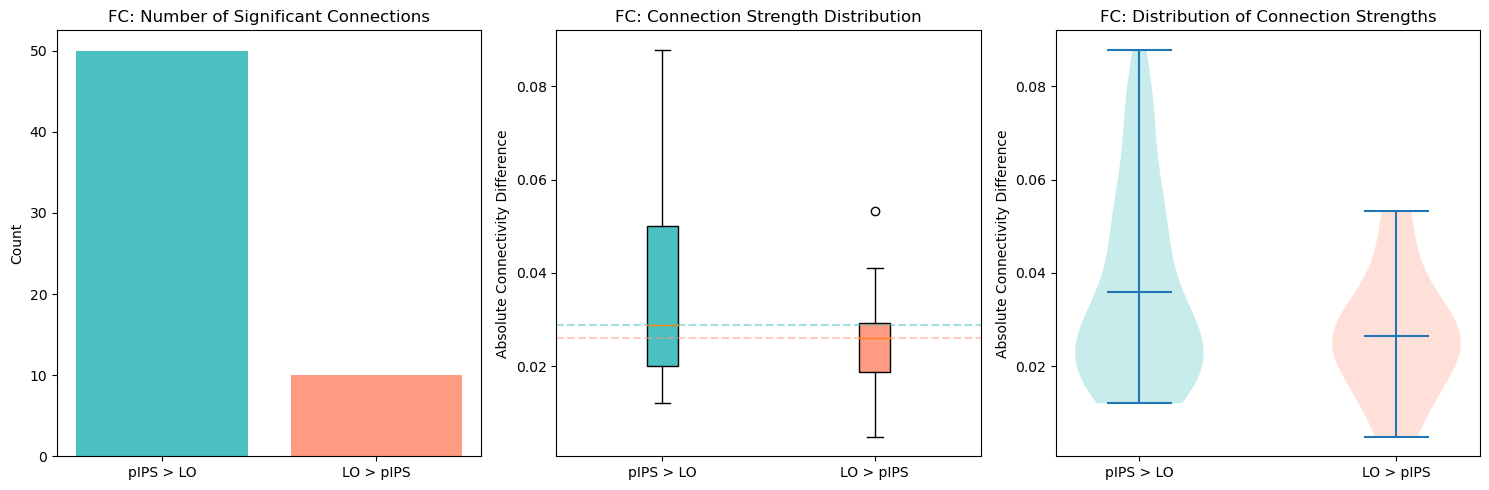


FC analysis complete. Results saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_asymmetry

ANALYZING PPI ASYMMETRY IN CONNECTIONS BETWEEN pIPS AND LO...
Merged atlas files found. Analysis will use results from merged atlas approach.
Loaded PPI connectivity data with 200 ROIs
Found 19 significant ROIs
pIPS > LO: 9 regions
LO > pIPS: 10 regions

Chi-square test for asymmetry in number of connections:
Observed frequencies: pIPS > LO: 9, LO > pIPS: 10
Expected frequencies: pIPS > LO: 9.5, LO > pIPS: 9.5
Chi-square statistic: 0.0526
p-value: 0.81854581
The asymmetry in number of connections is not statistically significant.

Mean strength of pIPS-dominant connections: 0.0039 ± 0.0021
Mean strength of LO-dominant connections: 0.0067 ± 0.0021

Mann-Whitney U test for connection strength differences:
U statistic: 17.0
p-value: 0.02474467
LO-dominant connections are significantly stronger than pIPS-dominant connections (p = 0.0247).

Total connectivity strength:
pIPS: 0.0347 (ac

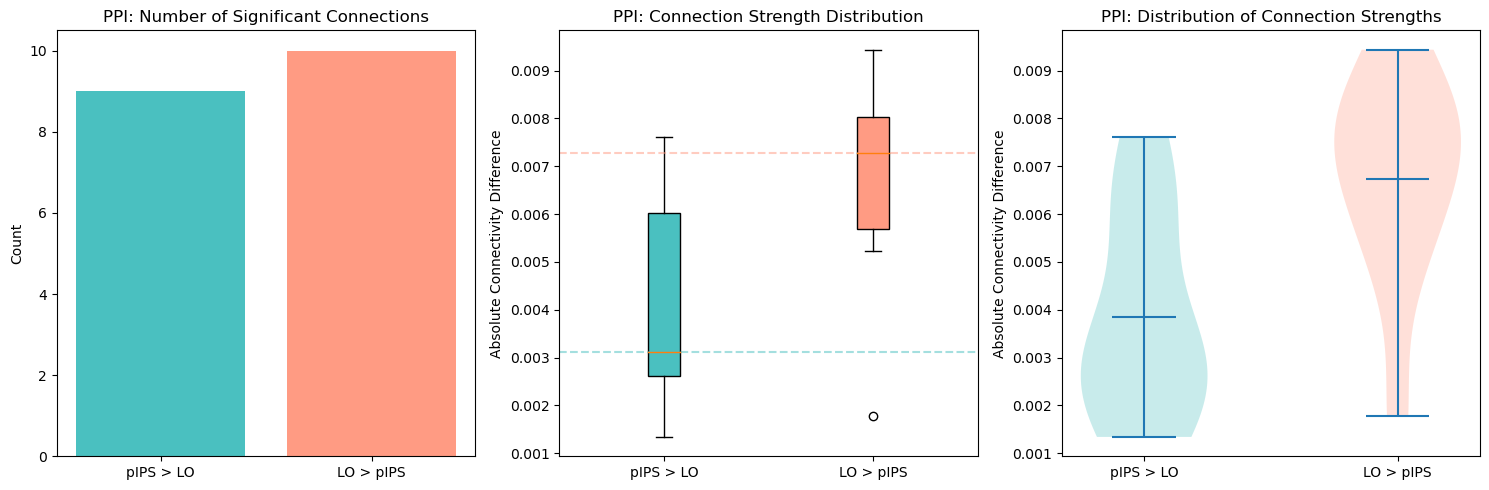


PPI analysis complete. Results saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_asymmetry

COMPARISON SUMMARY: FC vs PPI ASYMMETRY ANALYSIS

Number of significant connections:
FC: pIPS > LO: 50, LO > pIPS: 10
PPI: pIPS > LO: 9, LO > pIPS: 10

Asymmetry significance:
FC: Chi-square = 26.6667, p = 0.00000024
PPI: Chi-square = 0.0526, p = 0.81854581

Connection strength metrics:
FC:
  pIPS mean: 0.0359, median: 0.0288
  LO mean: 0.0266, median: 0.0261
  Ratio pIPS/LO total: 6.76
PPI:
  pIPS mean: 0.0039, median: 0.0031
  LO mean: 0.0067, median: 0.0073
  Ratio pIPS/LO total: 0.51


In [29]:
# chi squared test for independence
# Chi-square comparison of pIPS>LO connectivities for both FC and PPI
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

def analyze_connectivity_asymmetry(analysis_type='fc'):
    """
    Analyze the asymmetry in number and strength of connections for pIPS and LO regions.
    Tests whether pIPS has significantly more and stronger connections than LO.
    Uses Mann-Whitney U test for strength comparison to handle unequal sample sizes.
    
    Parameters:
    -----------
    analysis_type : str
        Type of analysis to perform, either 'fc' or 'ppi'
    """
    # Define paths
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
    connectivity_dir = f'{results_dir}/connectivity_comparison'
    output_dir = f'{results_dir}/connectivity_asymmetry'
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"\n{'='*80}")
    print(f"ANALYZING {analysis_type.upper()} ASYMMETRY IN CONNECTIONS BETWEEN pIPS AND LO...")
    print(f"{'='*80}")
    
    # Check if merged atlas exists (for information only, not used directly in this script)
    merged_atlas_file = f'{results_dir}/schaefer_wang_merged.nii.gz'
    merged_labels_file = f'{results_dir}/merged_atlas_labels.npy'
    
    if not os.path.exists(merged_atlas_file) or not os.path.exists(merged_labels_file):
        print("Warning: Merged atlas files not found. Results may not reflect merged atlas.")
    else:
        print("Merged atlas files found. Analysis will use results from merged atlas approach.")
    
    # Load connectivity results from CSV
    results_path = f'{connectivity_dir}/bilateral_{analysis_type}_connectivity_fingerprint_results.csv'
    if not os.path.exists(results_path):
        print(f"Error: Could not find {analysis_type.upper()} connectivity results at {results_path}")
        return None
    
    results_df = pd.read_csv(results_path)
    print(f"Loaded {analysis_type.upper()} connectivity data with {len(results_df)} ROIs")
    
    # Filter to significant regions according to the combined criteria
    sig_regions = results_df[results_df['Combined_Significant'] == True]
    print(f"Found {len(sig_regions)} significant ROIs")
    
    # Count regions by direction
    pips_stronger_count = sum(sig_regions['Direction'] == 'pIPS > LO')
    lo_stronger_count = sum(sig_regions['Direction'] == 'LO > pIPS')
    
    print(f"pIPS > LO: {pips_stronger_count} regions")
    print(f"LO > pIPS: {lo_stronger_count} regions")
    
    # 1. Chi-square test for number of connections
    observed = np.array([pips_stronger_count, lo_stronger_count])
    expected = np.array([observed.sum()/2, observed.sum()/2])  # Expected under null hypothesis of equal distribution
    
    chi2, p_value = stats.chisquare(observed, expected)
    
    print("\nChi-square test for asymmetry in number of connections:")
    print(f"Observed frequencies: pIPS > LO: {observed[0]}, LO > pIPS: {observed[1]}")
    print(f"Expected frequencies: pIPS > LO: {expected[0]}, LO > pIPS: {expected[1]}")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.8f}")
    
    if p_value < 0.05:
        print("The asymmetry in number of connections is statistically significant.")
        if pips_stronger_count > lo_stronger_count:
            print(f"pIPS has significantly more connections than LO (p {'< .001' if p_value < 0.001 else f'= {p_value:.4f}'}).")
        else:
            print(f"LO has significantly more connections than pIPS (p {'< .001' if p_value < 0.001 else f'= {p_value:.4f}'}).")
    else:
        print("The asymmetry in number of connections is not statistically significant.")
    
    # 2. Extract connectivity strength values for significant regions
    pips_stronger = np.abs(sig_regions[sig_regions['Direction'] == 'pIPS > LO']['Difference'].values)
    lo_stronger = np.abs(sig_regions[sig_regions['Direction'] == 'LO > pIPS']['Difference'].values)
    
    pips_mean = np.mean(pips_stronger) if len(pips_stronger) > 0 else 0
    pips_std = np.std(pips_stronger) if len(pips_stronger) > 0 else 0
    lo_mean = np.mean(lo_stronger) if len(lo_stronger) > 0 else 0
    lo_std = np.std(lo_stronger) if len(lo_stronger) > 0 else 0
    
    print(f"\nMean strength of pIPS-dominant connections: {pips_mean:.4f} ± {pips_std:.4f}")
    print(f"Mean strength of LO-dominant connections: {lo_mean:.4f} ± {lo_std:.4f}")
    
    # Mann-Whitney U test for comparing strength distributions (better for unequal sample sizes)
    u_stat = None
    p_value_mw = None
    
    if len(pips_stronger) > 0 and len(lo_stronger) > 0:
        u_stat, p_value_mw = stats.mannwhitneyu(pips_stronger, lo_stronger, alternative='two-sided')
        
        print("\nMann-Whitney U test for connection strength differences:")
        print(f"U statistic: {u_stat}")
        print(f"p-value: {p_value_mw:.8f}")
        
        if p_value_mw < 0.05:
            if np.median(pips_stronger) > np.median(lo_stronger):
                print(f"pIPS-dominant connections are significantly stronger than LO-dominant connections (p {'< .001' if p_value_mw < 0.001 else f'= {p_value_mw:.4f}'}).")
            else:
                print(f"LO-dominant connections are significantly stronger than pIPS-dominant connections (p {'< .001' if p_value_mw < 0.001 else f'= {p_value_mw:.4f}'}).")
        else:
            print("No significant difference in connection strength between pIPS-dominant and LO-dominant regions.")
        
        # Also calculate total connectivity strength
        pips_total = np.sum(pips_stronger)
        lo_total = np.sum(lo_stronger)
        print("\nTotal connectivity strength:")
        print(f"pIPS: {pips_total:.4f} (across {len(pips_stronger)} connections)")
        print(f"LO: {lo_total:.4f} (across {len(lo_stronger)} connections)")
        if lo_total > 0:
            print(f"Ratio pIPS/LO: {pips_total/lo_total:.2f}")
    else:
        pips_total = np.sum(pips_stronger) if len(pips_stronger) > 0 else 0
        lo_total = np.sum(lo_stronger) if len(lo_stronger) > 0 else 0
        print("Cannot perform strength comparison: insufficient data in one or both groups.")
    
    # 3. Create visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot number of connections
    plt.subplot(1, 3, 1)
    plt.bar(['pIPS > LO', 'LO > pIPS'], [pips_stronger_count, lo_stronger_count], 
            color=['#4ac0c0', '#ff9b83'])  # Using the same colors as in the original script
    plt.title(f'{analysis_type.upper()}: Number of Significant Connections')
    plt.ylabel('Count')
    
    # Plot connection strengths with boxplot
    if len(pips_stronger) > 0 and len(lo_stronger) > 0:
        plt.subplot(1, 3, 2)
        boxplot = plt.boxplot([pips_stronger, lo_stronger], labels=['pIPS > LO', 'LO > pIPS'], 
                  patch_artist=True)
        
        # Set colors to match the bar plot
        boxplot['boxes'][0].set_facecolor('#4ac0c0')
        boxplot['boxes'][1].set_facecolor('#ff9b83')
        
        plt.title(f'{analysis_type.upper()}: Connection Strength Distribution')
        plt.ylabel('Absolute Connectivity Difference')
        
        # Add median lines to the plot
        plt.axhline(y=np.median(pips_stronger), color='#4ac0c0', linestyle='--', alpha=0.5)
        plt.axhline(y=np.median(lo_stronger), color='#ff9b83', linestyle='--', alpha=0.5)
        
        # Plot violin plot to better visualize distributions
        plt.subplot(1, 3, 3)
        violin = plt.violinplot([pips_stronger, lo_stronger], showmeans=True)
        
        # Customize violin plot colors
        for i, pc in enumerate(violin['bodies']):
            if i == 0:
                pc.set_facecolor('#4ac0c0')
            else:
                pc.set_facecolor('#ff9b83')
        
        plt.xticks([1, 2], ['pIPS > LO', 'LO > pIPS'])
        plt.title(f'{analysis_type.upper()}: Distribution of Connection Strengths')
        plt.ylabel('Absolute Connectivity Difference')
    else:
        # If one or both groups are empty, create simple placeholder plots
        plt.subplot(1, 3, 2)
        plt.text(0.5, 0.5, 'Insufficient data\nfor comparison', 
                 ha='center', va='center', fontsize=12)
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.text(0.5, 0.5, 'Insufficient data\nfor comparison', 
                 ha='center', va='center', fontsize=12)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{analysis_type}_connectivity_asymmetry_analysis.png', dpi=300)
    plt.show()
    
    print(f"\n{analysis_type.upper()} analysis complete. Results saved to {output_dir}")
    
    # Calculate median values safely
    pips_median = np.median(pips_stronger) if len(pips_stronger) > 0 else None
    lo_median = np.median(lo_stronger) if len(lo_stronger) > 0 else None
    
    return {
        'analysis_type': analysis_type,
        'number_test': {'chi2': chi2, 'p_value': p_value},
        'strength_test': {'u_stat': u_stat, 'p_value': p_value_mw},
        'counts': {'pips_stronger': pips_stronger_count, 'lo_stronger': lo_stronger_count},
        'strengths': {'pips_mean': pips_mean,
                      'lo_mean': lo_mean,
                      'pips_median': pips_median,
                      'lo_median': lo_median,
                      'pips_total': pips_total,
                      'lo_total': lo_total}
    }

# Run the analysis for both FC and PPI
if __name__ == "__main__":
    # Run analysis for FC
    fc_results = analyze_connectivity_asymmetry(analysis_type='fc')
    
    # Run analysis for PPI
    ppi_results = analyze_connectivity_asymmetry(analysis_type='ppi')
    
    # Print a summary comparing both analyses
    if fc_results and ppi_results:
        print("\n" + "="*80)
        print("COMPARISON SUMMARY: FC vs PPI ASYMMETRY ANALYSIS")
        print("="*80)
        
        # Compare number of significant connections
        print("\nNumber of significant connections:")
        print(f"FC: pIPS > LO: {fc_results['counts']['pips_stronger']}, LO > pIPS: {fc_results['counts']['lo_stronger']}")
        print(f"PPI: pIPS > LO: {ppi_results['counts']['pips_stronger']}, LO > pIPS: {ppi_results['counts']['lo_stronger']}")
        
        # Compare significance of asymmetry
        print("\nAsymmetry significance:")
        print(f"FC: Chi-square = {fc_results['number_test']['chi2']:.4f}, p = {fc_results['number_test']['p_value']:.8f}")
        print(f"PPI: Chi-square = {ppi_results['number_test']['chi2']:.4f}, p = {ppi_results['number_test']['p_value']:.8f}")
        
        # Compare connection strengths (with safety checks)
        print("\nConnection strength metrics:")
        
        print("FC:")
        if fc_results['strengths']['pips_mean'] is not None:
            print(f"  pIPS mean: {fc_results['strengths']['pips_mean']:.4f}", end="")
            if fc_results['strengths']['pips_median'] is not None:
                print(f", median: {fc_results['strengths']['pips_median']:.4f}")
            else:
                print()
        
        if fc_results['strengths']['lo_mean'] is not None:
            print(f"  LO mean: {fc_results['strengths']['lo_mean']:.4f}", end="")
            if fc_results['strengths']['lo_median'] is not None:
                print(f", median: {fc_results['strengths']['lo_median']:.4f}")
            else:
                print()
        
        if fc_results['strengths']['lo_total'] > 0:
            print(f"  Ratio pIPS/LO total: {fc_results['strengths']['pips_total']/fc_results['strengths']['lo_total']:.2f}")
        
        print("PPI:")
        if ppi_results['strengths']['pips_mean'] is not None:
            print(f"  pIPS mean: {ppi_results['strengths']['pips_mean']:.4f}", end="")
            if ppi_results['strengths']['pips_median'] is not None:
                print(f", median: {ppi_results['strengths']['pips_median']:.4f}")
            else:
                print()
        
        if ppi_results['strengths']['lo_mean'] is not None:
            print(f"  LO mean: {ppi_results['strengths']['lo_mean']:.4f}", end="")
            if ppi_results['strengths']['lo_median'] is not None:
                print(f", median: {ppi_results['strengths']['lo_median']:.4f}")
            else:
                print()
        
        if ppi_results['strengths']['lo_total'] > 0:
            print(f"  Ratio pIPS/LO total: {ppi_results['strengths']['pips_total']/ppi_results['strengths']['lo_total']:.2f}")